Ben Ghertner 2025

Compute the nonlinear wave solution of Chapter 4 and plots of the modes at each correction.

    - Figure 4.1
    - Figure 4.2
    - Figure 4.3
    - Figure 4.4
    - Figure 4.5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.usetex'] = True
plt.rcParams["font.size"] = 11

%matplotlib inline

In [2]:
# Uses secant method to numerically solve the dispersion relationship Det(M) = 0 
# with M given in Eq (3.44) for the frequency of the wave
#
# input:
#       om_0 - first guess at frequency
#       N2c  - buoyancy frequency in cloud
#       N2i  - buoyancy frequency in inversion (clear)
#       N2t  - buoyancy frequency in troposphere (above inversion)
#       Hc   - nominal height of cloud edge 
#       Hi   - nominal height of inversion edge
#       HT   - domain top height 
# returns:
#       om   - frequency (numerically) satisfying Det(M) = 0
def secant_omega(om_0, N2c, N2i, N2t, Hc, Hi, HT, k):
    # Dispersion relationship function Det(M) 
    # as a function of the frequency
    #
    # input:
    #       om - frequency
    # returns:
    #       Det(M) from Eq (3.44)
    def f(om):
        #Vertical wavenumbers
        mt = k*np.sqrt(1 - N2t/om**2)
        mi = k*np.sqrt(N2i/om**2 - 1)
        mc = k*np.sqrt(1 - N2c/om**2)
        
        #as in Eq (3.44)
        M = np.array([[mt*np.sin(mi*Hi)/np.tanh(mt*(Hi-HT)) - mi*np.cos(mi*Hi),
                       mt*np.cos(mi*Hi)/np.tanh(mt*(Hi-HT)) + mi*np.sin(mi*Hi)],

                      [mi*np.cos(mi*Hc) - mc*np.sin(mi*Hc)/np.tanh(mc*Hc),
                      -mi*np.sin(mi*Hc) - mc*np.cos(mi*Hc)/np.tanh(mc*Hc)]])
        return np.linalg.det(M)
    #Initialize first guesses at the frequency
    om_m1 = om_0
    om_m2 = om_0*(1.001)
    #Iterate until tolerance is met
    while(np.abs((om_m1-om_m2)/om_m1)>1e-15):
        #Save last guess
        temp = om_m1
        #Secant step
        om_m1 = om_m1 - f(om_m1)*(om_m1-om_m2)/(f(om_m1)-f(om_m2))
        #update last guess
        om_m2 = temp
        
    return om_m1

In [3]:
#sympy symbols (variables)
k, z, x, t, X, T, L = sym.symbols('k, z, x, t, X, T, L', real=True)
om, om_p = sym.symbols("omega omega_k", real=True)
c = om/k
I = sym.I #sympy imaginary unit for convience

#####################################################
#                                                   #
#                   From Table 4.1                  #
#                                                   #
#####################################################
N2c = (2*np.pi)**2
N2i = 2*(2*np.pi)**2
N2t = np.pi**2

Hc = 2.
Hi = 4.
HT = 10.0

mt = k*sym.sqrt(1 - N2t/om**2)
mi = k*sym.sqrt(N2i/om**2 - 1)
mc = k*sym.sqrt(1 - N2c/om**2)

k_val  = 2.2
#Find frequency for the given wavenumber and parameters
om_val = secant_omega(2.5*np.pi+0.j, N2c=N2c, N2i=N2i, N2t=N2t, Hc=Hc, Hi=Hi, HT=HT, k=k_val)

print(f'omega: {om_val:.5f}')
print(f'mt:    {mt.subs({k:k_val,om:om_val}):.5f}')
print(f'mi:    {mi.subs({k:k_val,om:om_val}):.5f}')
print(f'mc:    {mc.subs({k:k_val,om:om_val})}')

omega: 8.06055+0.00000j
mt:    2.02603
mi:    1.02066
mc:    1.37808969935558


In [4]:
# Helpful function to plug in k and omega values and evaluate
#
# inputs:
#       f      - sympy expression to be evaluated
#       z      - evalutation points
#       k_val  - numerical value of the horizontal wavenumber
#       om_val - numerical value of the frequency of the wave
#       L_val  - latent heat response
# returns:
#       f_eval - the expression f evaluated at the given points
def sym_to_eval(f, zz, k_val=k_val, om_val=om_val, L_val=2.76):
    val_dict = {
        k:   k_val,
        om:  om_val,
        L:   L_val
    }
    return sym.lambdify(z, f.subs(val_dict))(zz)

**Put together the linear solution as in section 3.3.1**

In [5]:
#Matrix elements of M from Eq (3.44)
a = mt*sym.sin(mi*Hi)/sym.tanh(mt*(Hi-HT)) - mi*sym.cos(mi*Hi)
b = mt*sym.cos(mi*Hi)/sym.tanh(mt*(Hi-HT)) + mi*sym.sin(mi*Hi)

c = mi*sym.cos(mi*Hc) - mc*sym.sin(mi*Hc)/sym.tanh(mc*Hc)
d =-mi*sym.sin(mi*Hc) - mc*sym.cos(mi*Hc)/sym.tanh(mc*Hc)

#Eigenvectors - make sure eigenvector 1 is the zero eigenvector
print('lambda1 needs to be (numerically) 0')
print(f'lambda2 : {(1/2)*(sym.sqrt((a - d)**2 + 4*b*c) + a + d).subs({k:   k_val, om:  om_val})}')
v2 = [
    (a - d + sym.sqrt((a - d)**2 + 4*b*c))/(2*c),
    1
]

print(f'lambda1 : {(1/2)*(-sym.sqrt((a - d)**2 + 4*b*c) + a + d).subs({k:   k_val, om:  om_val})}')
v1 = [
    (a - d - sym.sqrt((a - d)**2 + 4*b*c))/(2*c),
    1
]

lambda1 needs to be (numerically) 0
lambda2 : 1.95855286165579
lambda1 : -2.83106871279415E-15


In [6]:
#First harmonic continuous fundamental solutions in each region Eq (3.43)
psia_t = sym.sin(mi*Hi)*sym.sinh(mt*(z-HT))/sym.sinh(mt*(Hi-HT))
psia_i = sym.sin(mi*z)
psia_c = sym.sin(mi*Hc)*sym.sinh(mc*z)/sym.sinh(mc*Hc)

psib_t = sym.cos(mi*Hi)*sym.sinh(mt*(z-HT))/sym.sinh(mt*(Hi-HT))
psib_i = sym.cos(mi*z)
psib_c = sym.cos(mi*Hc)*sym.sinh(mc*z)/sym.sinh(mc*Hc)

#Leading order normal mode with continuity and derivative continuity
psih_0_t = v1[0]*psia_t + v1[1]*psib_t
psih_0_i = v1[0]*psia_i + v1[1]*psib_i
psih_0_c = v1[0]*psia_c + v1[1]*psib_c

#Leading order buoyancy normal mode Eq (3.33)
Bh_0_t   = N2t*k/om*psih_0_t
Bh_0_i   = N2i*k/om*psih_0_i
Bh_0_c   = N2c*k/om*psih_0_c

#Leading order wave displacement Eq (3.33)
Zih_0     =       -k/om*psih_0_i.subs({z: Hi})
Zch_0     = -(1+L)*k/om*psih_0_i.subs({z: Hc})

In [7]:
#phi function Eq (4.10)
phi_t = v2[0]*psia_t + v2[1]*psib_t
phi_i = v2[0]*psia_i + v2[1]*psib_i
phi_c = v2[0]*psia_c + v2[1]*psib_c

#phi derivative jump at inversion
J_dphi = sym_to_eval(sym.diff(phi_t,z), Hi)-sym_to_eval(sym.diff(phi_i,z), Hi)

In [8]:
#Compute psi^X, psi^T Eq (4.11)
psih_X_t = -I*sym.diff(psih_0_t, k)
psih_X_i = -I*sym.diff(psih_0_i, k)
psih_X_c = -I*sym.diff(psih_0_c, k)

psih_T_t =  I*sym.diff(psih_0_t, om)
psih_T_i =  I*sym.diff(psih_0_i, om)
psih_T_c =  I*sym.diff(psih_0_c, om)

# Add phi to make derivative continuity at Hi
del_X_Hi = sym_to_eval(sym.diff(psih_X_t,z), Hi)-sym_to_eval(sym.diff(psih_X_i,z), Hi)
del_T_Hi = sym_to_eval(sym.diff(psih_T_t,z), Hi)-sym_to_eval(sym.diff(psih_T_i,z), Hi)
del_X_Hc = sym_to_eval(sym.diff(psih_X_i,z), Hc)-sym_to_eval(sym.diff(psih_X_c,z), Hc)
del_T_Hc = sym_to_eval(sym.diff(psih_T_i,z), Hc)-sym_to_eval(sym.diff(psih_T_c,z), Hc)

alpha_X = -del_X_Hi/J_dphi
alpha_T = -del_T_Hi/J_dphi

psih_X_t += alpha_X*phi_t
psih_X_i += alpha_X*phi_i
psih_X_c += alpha_X*phi_c

psih_T_t += alpha_T*phi_t
psih_T_i += alpha_T*phi_i
psih_T_c += alpha_T*phi_c

#Compute group velocity based on jumps in psi^X and psi^T Eq (4.16)
del_X = sym_to_eval(sym.diff(psih_X_i,z), Hc)-sym_to_eval(sym.diff(psih_X_c,z), Hc)
del_T = sym_to_eval(sym.diff(psih_T_i,z), Hc)-sym_to_eval(sym.diff(psih_T_c,z), Hc)

om_p = del_X/del_T

#Linear first correction buoyancy Eq (4.27)
Bh_X_t = N2t*k/om*psih_X_t - I*N2t/om*psih_0_t
Bh_X_i = N2i*k/om*psih_X_i - I*N2i/om*psih_0_i
Bh_X_c = N2c*k/om*psih_X_c - I*N2c/om*psih_0_c

Bh_T_t =  N2t*k/om*psih_T_t - I*N2t*k/om**2*psih_0_t
Bh_T_i =  N2i*k/om*psih_T_i - I*N2i*k/om**2*psih_0_i
Bh_T_c =  N2c*k/om*psih_T_c - I*N2c*k/om**2*psih_0_c

#Linear first correction to interface displacement Eq (4.27)
Zih_X   =  -k/om*psih_X_i.subs({z:Hi}) + I/om*psih_0_i.subs({z:Hi})
Zih_T   =  -k/om*psih_T_i.subs({z:Hi}) + I*k/om**2*psih_0_i.subs({z:Hi})

Zch_X   =  -(1+L)*k/om*psih_X_i.subs({z:Hc}) + (1+L)*I/om*psih_0_i.subs({z:Hc})
Zch_T   =  -(1+L)*k/om*psih_T_i.subs({z:Hc}) + (1+L)*I*k/om**2*psih_0_i.subs({z:Hc})

**Figure 4.1**

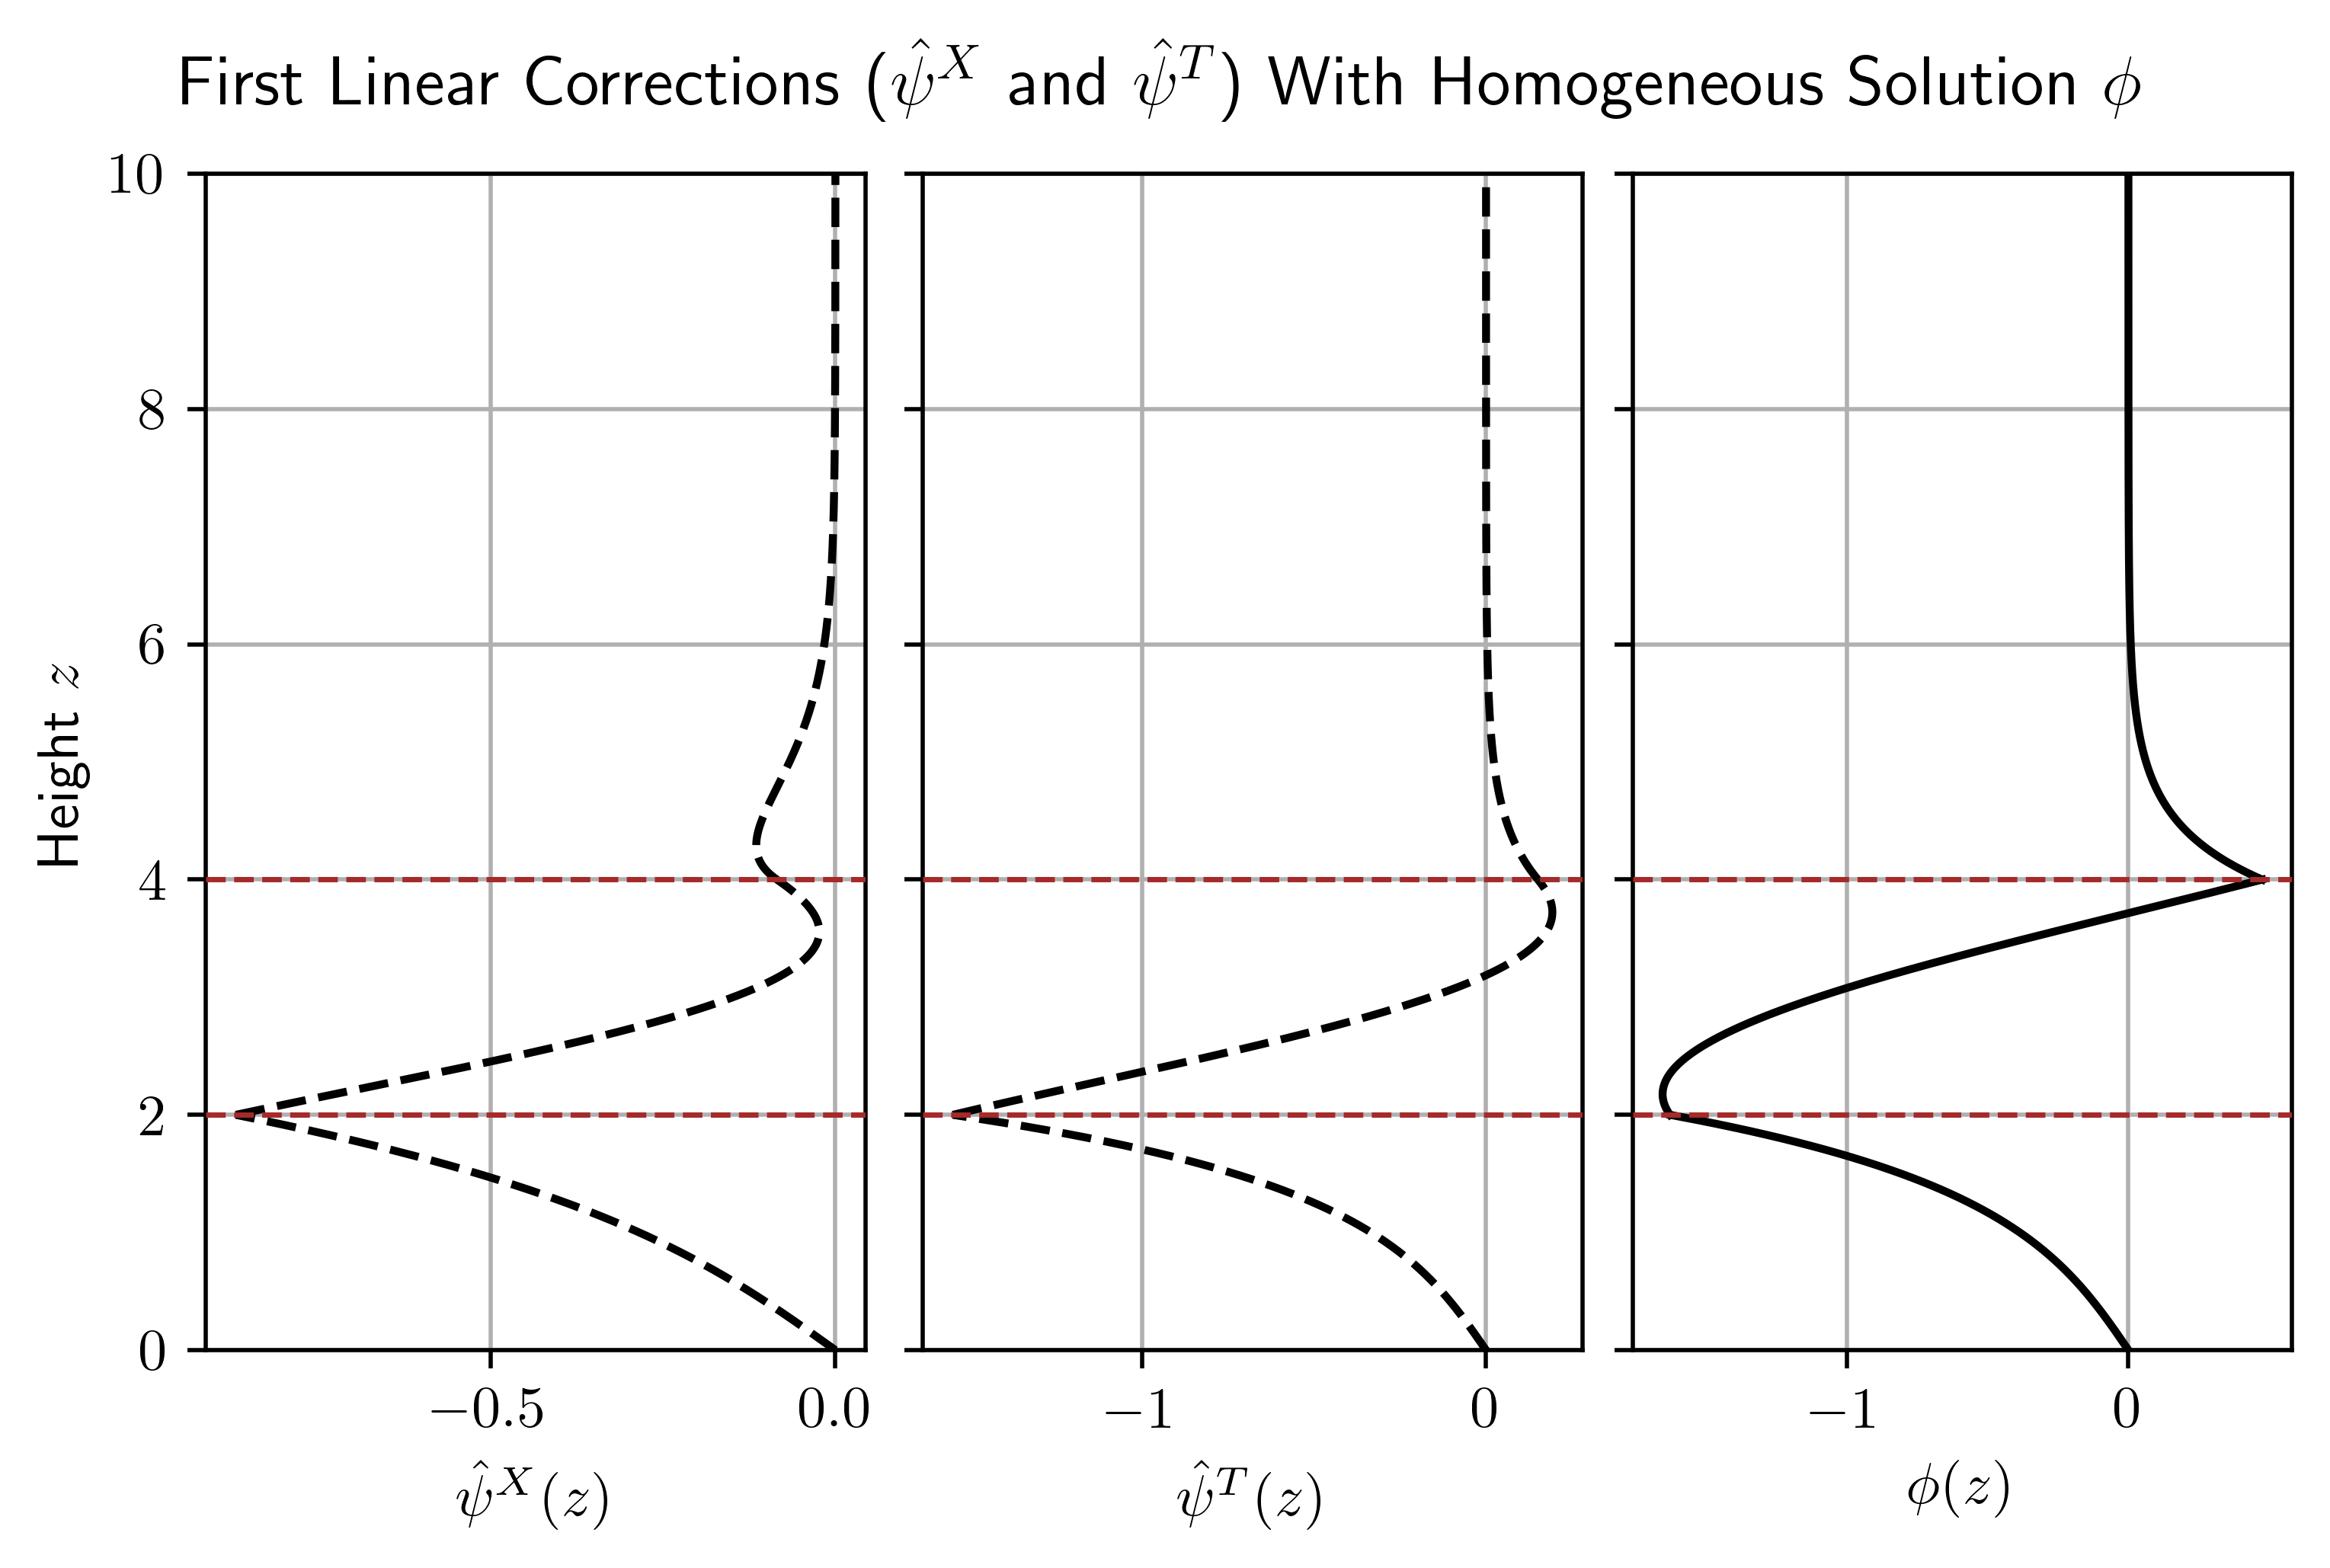

In [9]:
fig, axes = plt.subplots(layout='constrained', ncols=3, sharey=True)
fig.set_size_inches(6, 4.0)
fig.set_dpi(500)

zt = np.linspace(Hi, HT, num=1000)
zi = np.linspace(Hc, Hi, num=1000)
zc = np.linspace(0., Hc, num=1000)

axes[0].plot(sym_to_eval(psih_X_t, zt).imag, zt, '--k', zorder=3)
axes[0].plot(sym_to_eval(psih_X_i, zi).imag, zi, '--k', zorder=3)
axes[0].plot(sym_to_eval(psih_X_c, zc).imag, zc, '--k', zorder=3)
axes[0].grid()
axes[0].set(ylim=(0, HT))
axes[0].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[0].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[0].set(xlabel=r'$\hat{\psi}^X(z)$', ylabel=r'Height $z$')

axes[1].plot(sym_to_eval(psih_T_t, zt).imag, zt, '--k', zorder=3)
axes[1].plot(sym_to_eval(psih_T_i, zi).imag, zi, '--k', zorder=3)
axes[1].plot(sym_to_eval(psih_T_c, zc).imag, zc, '--k', zorder=3)
axes[1].grid()
axes[1].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[1].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[1].set(xlabel=r'$\hat{\psi}^T(z)$')

axes[2].plot(sym_to_eval(phi_t, zt).real, zt, 'k', zorder=3)
axes[2].plot(sym_to_eval(phi_i, zi).real, zi, 'k', zorder=3)
axes[2].plot(sym_to_eval(phi_c, zc).real, zc, 'k', zorder=3)
axes[2].grid()
axes[2].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[2].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[2].set(xlabel=r'$\phi(z)$')

fig.suptitle(r'First Linear Corrections ($\hat{\psi}^X$ and $\hat{\psi}^T$)'+''+r' With Homogeneous Solution $\phi$')

plt.show()


In [10]:
#Compute psi^XX, psi^TX, psi^TT Eq (4.28-4.30)
psih_XX_t = -sym.diff(psih_0_t, k, k)/2 - I*alpha_X*sym.diff(phi_t, k)
psih_XX_i = -sym.diff(psih_0_i, k, k)/2 - I*alpha_X*sym.diff(phi_i, k)
psih_XX_c = -sym.diff(psih_0_c, k, k)/2 - I*alpha_X*sym.diff(phi_c, k)

psih_TX_t =  sym.diff(psih_0_t, om, k) - I*alpha_T*sym.diff(phi_t, k) + I*alpha_X*sym.diff(phi_t, om)
psih_TX_i =  sym.diff(psih_0_i, om, k) - I*alpha_T*sym.diff(phi_i, k) + I*alpha_X*sym.diff(phi_i, om)
psih_TX_c =  sym.diff(psih_0_c, om, k) - I*alpha_T*sym.diff(phi_c, k) + I*alpha_X*sym.diff(phi_c, om)

psih_TT_t = -sym.diff(psih_0_t, om, om)/2 + I*alpha_T*sym.diff(phi_t, om)
psih_TT_i = -sym.diff(psih_0_i, om, om)/2 + I*alpha_T*sym.diff(phi_i, om)
psih_TT_c = -sym.diff(psih_0_c, om, om)/2 + I*alpha_T*sym.diff(phi_c, om)

del_XX_Hi = sym_to_eval(sym.diff(psih_XX_t,z), Hi)-sym_to_eval(sym.diff(psih_XX_i,z), Hi)
del_TX_Hi = sym_to_eval(sym.diff(psih_TX_t,z), Hi)-sym_to_eval(sym.diff(psih_TX_i,z), Hi)
del_TT_Hi = sym_to_eval(sym.diff(psih_TT_t,z), Hi)-sym_to_eval(sym.diff(psih_TT_i,z), Hi)

alpha_XX = -del_XX_Hi/J_dphi
alpha_TX = -del_TX_Hi/J_dphi
alpha_TT = -del_TT_Hi/J_dphi

psih_XX_t += alpha_XX*phi_t
psih_XX_i += alpha_XX*phi_i
psih_XX_c += alpha_XX*phi_c

psih_TX_t += alpha_TX*phi_t
psih_TX_i += alpha_TX*phi_i
psih_TX_c += alpha_TX*phi_c

psih_TT_t += alpha_TT*phi_t
psih_TT_i += alpha_TT*phi_i
psih_TT_c += alpha_TT*phi_c

#Compute second derivative of omega using jumps in psi^XX, psi^TX, psi^TT
del_XX_Hi = sym_to_eval(sym.diff(psih_XX_t,z), Hi)-sym_to_eval(sym.diff(psih_XX_i,z), Hi)
del_TX_Hi = sym_to_eval(sym.diff(psih_TX_t,z), Hi)-sym_to_eval(sym.diff(psih_TX_i,z), Hi)
del_TT_Hi = sym_to_eval(sym.diff(psih_TT_t,z), Hi)-sym_to_eval(sym.diff(psih_TT_i,z), Hi)

del_XX = sym_to_eval(sym.diff(psih_XX_i,z), Hc)-sym_to_eval(sym.diff(psih_XX_c,z), Hc)
del_TX = sym_to_eval(sym.diff(psih_TX_i,z), Hc)-sym_to_eval(sym.diff(psih_TX_c,z), Hc)
del_TT = sym_to_eval(sym.diff(psih_TT_i,z), Hc)-sym_to_eval(sym.diff(psih_TT_c,z), Hc)

om_pp = (del_XX/del_T + om_p**2*del_TT/del_T - om_p*del_TX/del_T)*2j

#Second linear correction to buoyancy
Bh_XX_t = N2t*k/om*psih_XX_t - I*N2t/om*psih_X_t
Bh_XX_i = N2i*k/om*psih_XX_i - I*N2i/om*psih_X_i
Bh_XX_c = N2c*k/om*psih_XX_c - I*N2c/om*psih_X_c

Bh_TX_t =  N2t*k/om*psih_TX_t - I*N2t/om*psih_T_t - I*N2t*k/om**2*psih_X_t - N2t/om**2*psih_0_t
Bh_TX_i =  N2i*k/om*psih_TX_i - I*N2i/om*psih_T_i - I*N2i*k/om**2*psih_X_i - N2i/om**2*psih_0_i
Bh_TX_c =  N2c*k/om*psih_TX_c - I*N2c/om*psih_T_c - I*N2c*k/om**2*psih_X_c - N2c/om**2*psih_0_c

Bh_TT_t = N2t*k/om*psih_TT_t - I*N2t*k/om**2*psih_T_t - N2t*k/om**3*psih_0_t
Bh_TT_i = N2i*k/om*psih_TT_i - I*N2i*k/om**2*psih_T_i - N2i*k/om**3*psih_0_i
Bh_TT_c = N2c*k/om*psih_TT_c - I*N2c*k/om**2*psih_T_c - N2c*k/om**3*psih_0_c

**Figure 4.2**

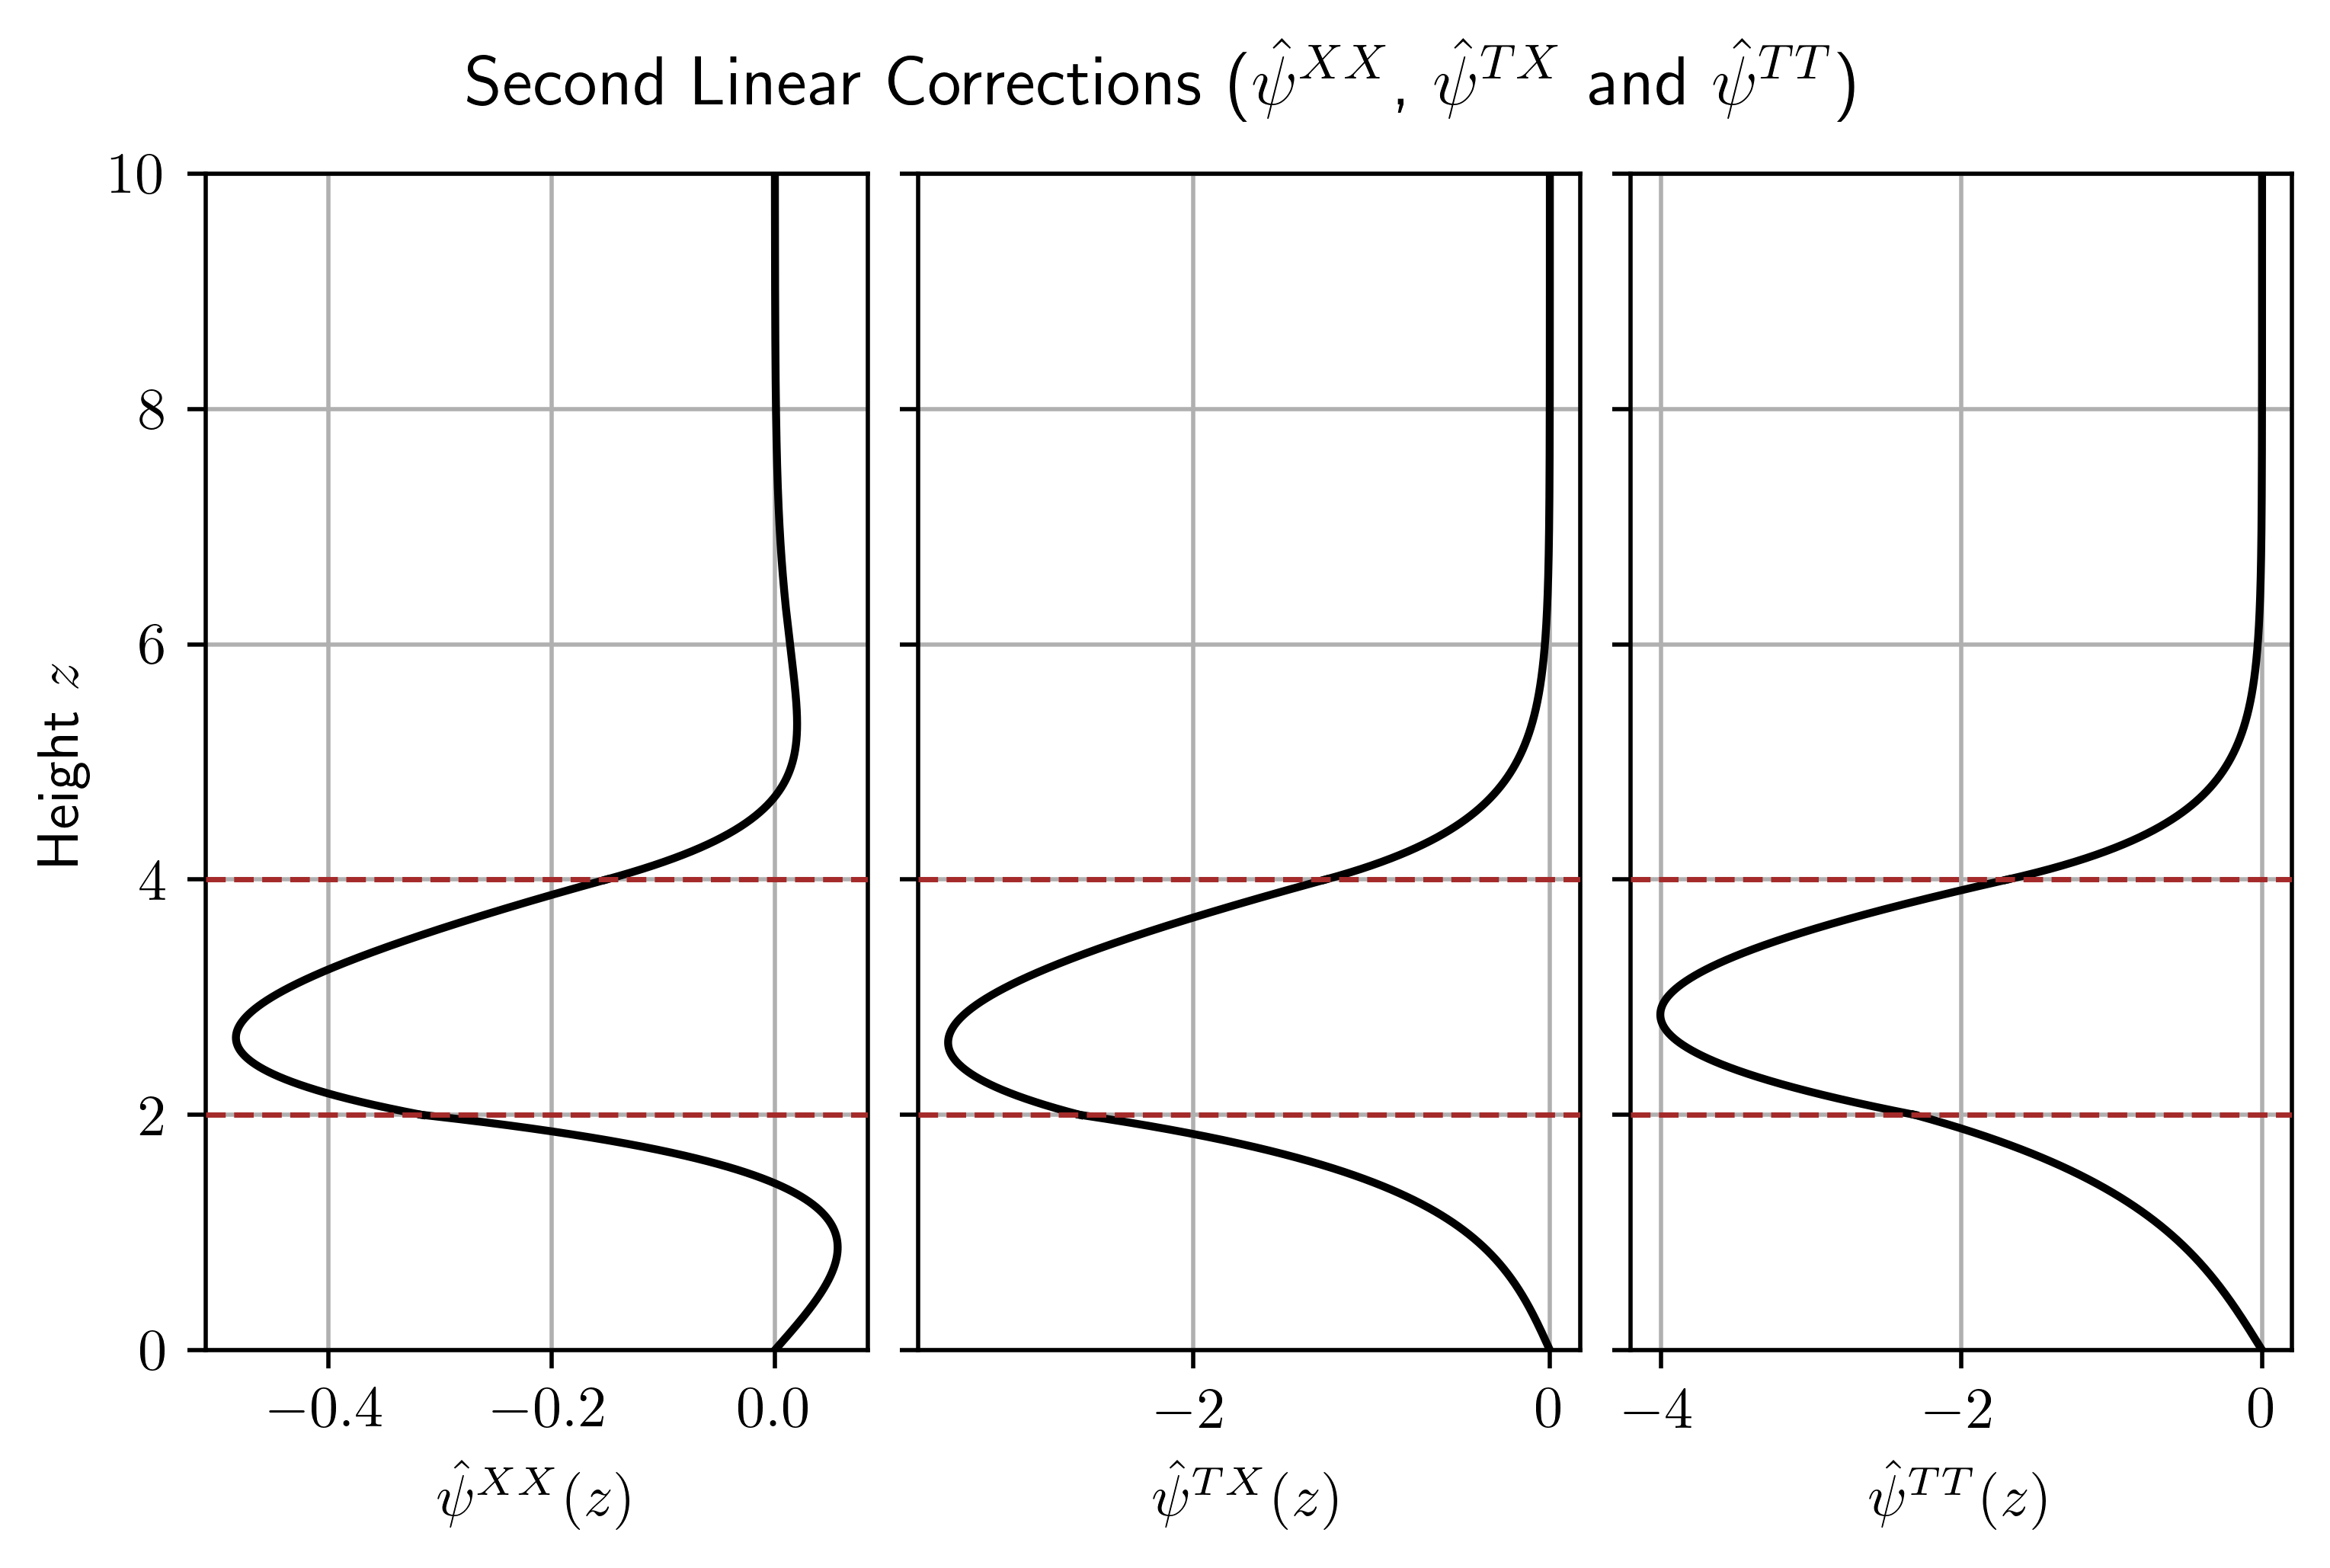

In [11]:
fig, axes = plt.subplots(layout='constrained', ncols=3, sharey=True)
fig.set_size_inches(6, 4.0)
fig.set_dpi(500)

zt = np.linspace(Hi, HT, num=1000)
zi = np.linspace(Hc, Hi, num=1000)
zc = np.linspace(0., Hc, num=1000)

axes[0].plot(sym_to_eval(psih_XX_t, zt).real, zt, 'k', zorder=3)
axes[0].plot(sym_to_eval(psih_XX_i, zi).real, zi, 'k', zorder=3)
axes[0].plot(sym_to_eval(psih_XX_c, zc).real, zc, 'k', zorder=3)
axes[0].grid()
axes[0].set(ylim=(0, HT))
axes[0].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[0].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[0].set(xlabel=r'$\hat{\psi}^{XX}(z)$', ylabel=r'Height $z$')

axes[1].plot(sym_to_eval(psih_TX_t, zt).real, zt, 'k', zorder=3)
axes[1].plot(sym_to_eval(psih_TX_i, zi).real, zi, 'k', zorder=3)
axes[1].plot(sym_to_eval(psih_TX_c, zc).real, zc, 'k', zorder=3)
axes[1].grid()
axes[1].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[1].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[1].set(xlabel=r'$\hat{\psi}^{TX}(z)$')

axes[2].plot(sym_to_eval(psih_TT_t, zt).real, zt, 'k', zorder=3)
axes[2].plot(sym_to_eval(psih_TT_i, zi).real, zi, 'k', zorder=3)
axes[2].plot(sym_to_eval(psih_TT_c, zc).real, zc, 'k', zorder=3)
axes[2].grid()
axes[2].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[2].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[2].set(xlabel=r'$\hat{\psi}^{TT}(z)$')

fig.suptitle(r'Second Linear Corrections ($\hat{\psi}^{XX}$, $\hat{\psi}^{TX}$ and $\hat{\psi}^{TT}$)')

plt.show()

**Nonlinear terms: first correction - second harmonic (Section 4.2.1)**

In [12]:
#vertical wavenumbers for this harmonic
m2t = k*sym.sqrt(4 - N2t/om**2)
m2i = k*sym.sqrt(N2i/om**2 - 4)
m2c = k*sym.sqrt(4 - N2c/om**2)

#Continuous fundamental solutions Eq (4.36)
psi2a_t = sym.sin(m2i*Hi)*sym.sinh(m2t*(z-HT))/sym.sinh(m2t*(Hi-HT))/sym.sin(m2i*Hi)
psi2a_i = sym.sin(m2i*z)/sym.sin(m2i*Hi)
psi2a_c = sym.sin(m2i*Hc)*sym.sinh(m2c*z)/sym.sinh(m2c*Hc)/sym.sin(m2i*Hi)

psi2b_t = sym.sinh(m2t*(z-HT))/sym.sinh(m2t*(Hi-HT))/sym.cos(m2i*(Hc-Hi))
psi2b_i = sym.cos(m2i*(z-Hi))/sym.cos(m2i*(Hc-Hi))
psi2b_c = sym.sinh(m2c*z)/sym.sinh(m2c*Hc)

#Matrix elements for M2 Eq (4.27)
J_dpsi2a_Hi = sym.diff(psi2a_t, z).subs({z:Hi}) - sym.diff(psi2a_i, z).subs({z:Hi})
J_dpsi2b_Hi = sym.diff(psi2b_t, z).subs({z:Hi}) - sym.diff(psi2b_i, z).subs({z:Hi})
J_dpsi2a_Hc = sym.diff(psi2a_i, z).subs({z:Hc}) - sym.diff(psi2a_c, z).subs({z:Hc})
J_dpsi2b_Hc = sym.diff(psi2b_i, z).subs({z:Hc}) - sym.diff(psi2b_c, z).subs({z:Hc})

M12 = sym.Matrix([[J_dpsi2a_Hi, J_dpsi2b_Hi],
                  [J_dpsi2a_Hc, J_dpsi2b_Hc]])

#RHS vector of Eq (4.27)
J_dpsi12_Hi = -k**3/om**3*(N2t-N2i)*(psih_0_i.subs({z:Hi}))**2
J_dpsi12_Hc = -(1+L)*k**3/om**3*(N2i-N2c)*(psih_0_i.subs({z:Hc}))**2

#Solve to form solution with correct derivative jump properties
W12 = M12.inv()@sym.Matrix([[J_dpsi12_Hi], [J_dpsi12_Hc]])

#Eq (4.38)
psih_12_t = W12[0,0]*psi2a_t + W12[1,0]*psi2b_t
psih_12_i = W12[0,0]*psi2a_i + W12[1,0]*psi2b_i
psih_12_c = W12[0,0]*psi2a_c + W12[1,0]*psi2b_c

#first correction - second harmonic - buoyancy Eq (4.39)
Bh_12_t   = N2t*k/om*psih_12_t
Bh_12_i   = N2i*k/om*psih_12_i
Bh_12_c   = N2c*k/om*psih_12_c

#first correction - second harmonic - interface displacement Eq (4.40-4.41)
Zih_12     = -k/om*psih_12_i.subs({z: Hi}) + 1/2*k**2/om**2*sym.diff(psih_0_i**2, z).subs({z:Hi})
Zch_12     = -(1+L)*k/om*psih_12_i.subs({z: Hc}) + (1+L)/4*k**2/om**2*(2+L)*sym.diff(psih_0_i**2, z).subs({z:Hc})

**Figure 4.3**

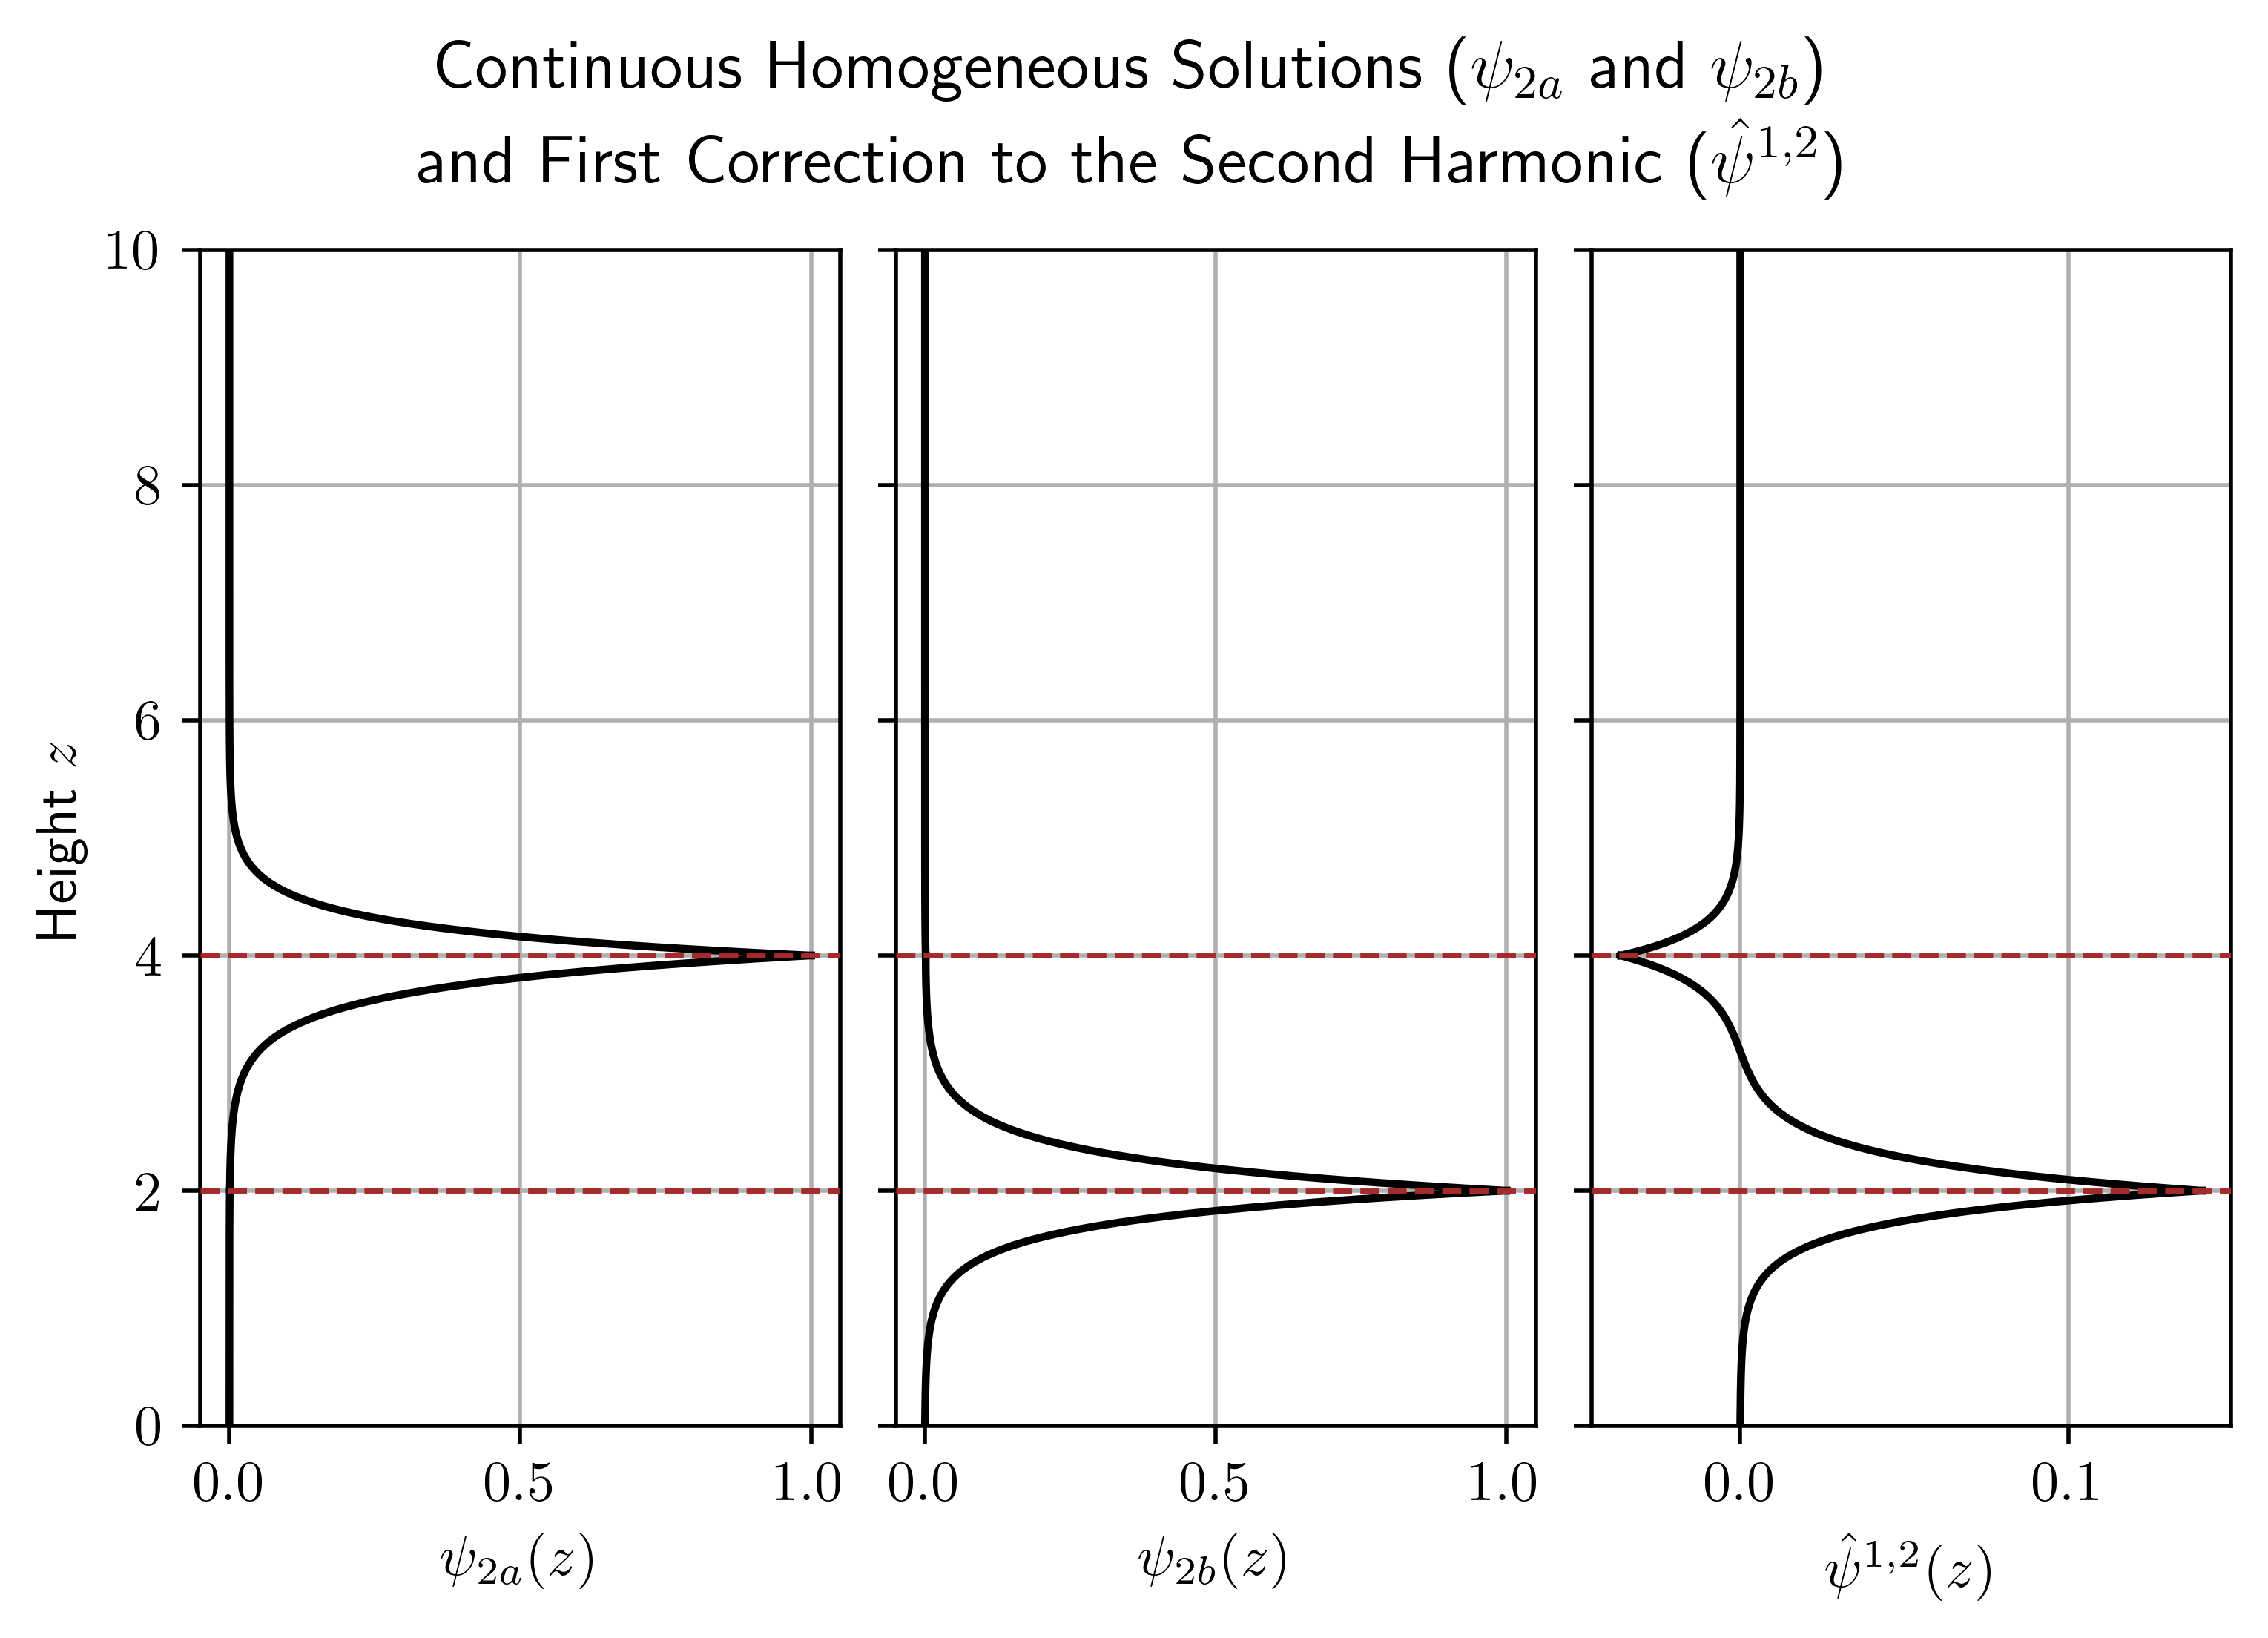

In [13]:
fig, axes = plt.subplots(layout='constrained', ncols=3, sharey=True)
fig.set_size_inches(6, 4.3)
fig.set_dpi(500)

zt = np.linspace(Hi, HT, num=1000)
zi = np.linspace(Hc, Hi, num=1000)
zc = np.linspace(0., Hc, num=1000)

axes[0].plot(sym_to_eval(psi2a_t, zt).real, zt, 'k', zorder=3)
axes[0].plot(sym_to_eval(psi2a_i, zi).real, zi, 'k', zorder=3)
axes[0].plot(sym_to_eval(psi2a_c, zc).real, zc, 'k', zorder=3)
axes[0].grid()
axes[0].set(ylim=(0, HT))
axes[0].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[0].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[0].set(xlabel=r'$\psi_{2a}(z)$', ylabel=r'Height $z$')

axes[1].plot(sym_to_eval(psi2b_t, zt).real, zt, 'k', zorder=3)
axes[1].plot(sym_to_eval(psi2b_i, zi).real, zi, 'k', zorder=3)
axes[1].plot(sym_to_eval(psi2b_c, zc).real, zc, 'k', zorder=3)
axes[1].grid()
axes[1].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[1].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[1].set(xlabel=r'$\psi_{2b}(z)$')

axes[2].plot(sym_to_eval(psih_12_t, zt).real, zt, 'k', zorder=3)
axes[2].plot(sym_to_eval(psih_12_i, zi).real, zi, 'k', zorder=3)
axes[2].plot(sym_to_eval(psih_12_c, zc).real, zc, 'k', zorder=3)
axes[2].grid()
axes[2].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[2].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[2].set(xlabel=r'$\hat\psi^{1,2}(z)$')

fig.suptitle(r'Continuous Homogeneous Solutions ($\psi_{2a}$ and $\psi_{2b}$)'+'\n'+r' and First Correction to the Second Harmonic ($\hat\psi^{1,2}$)')

plt.show()

**Nonlinear terms: first correction - mean mode/zeroth harmonic (Section 4.2.2)**

In [14]:
#For convience N rather than N^2
Nt = np.sqrt(N2t)
Ni = np.sqrt(N2i)
Nc = np.sqrt(N2c)

#Vertical wavenumbers
#Note these are different than the k->0 limit of the linear grav. wave
m0t = Nt/om_p
m0i = Ni/om_p
m0c = Nc/om_p

#First construct a continuous particular solution to the ODE Eq (4.45)
#not in my thesis but a second year student "should" be able to do this ;)
#The a, b and ab modes below are used to make a particular solution to each
#leading order forcing i.e. a cooresponds to a psi_a x psi_a forcing
psi10_pa_t = mt*sym.sin(mi*Hi)**2*sym.sinh(2*mt*(z-HT))/sym.sinh(mt*(Hi-HT))**2/(m0t**2 + 4*mt**2)
psi10_pa_i = mi*sym.sin(2*mi*z)/(m0i**2 - 4*mi**2)
psi10_pa_c = mc*sym.sin(mi*Hc)**2*sym.sinh(2*mc*z)/sym.sinh(mc*Hc)**2/(m0c**2 + 4*mc**2)

psi10_pb_t = mt*sym.cos(mi*Hi)**2*sym.sinh(2*mt*(z-HT))/sym.sinh(mt*(Hi-HT))**2/(m0t**2 + 4*mt**2)
psi10_pb_i = -mi*sym.sin(2*mi*z)/(m0i**2 - 4*mi**2)
psi10_pb_c = mc*sym.cos(mi*Hc)**2*sym.sinh(2*mc*z)/sym.sinh(mc*Hc)**2/(m0c**2 + 4*mc**2)

psi10_pab_t = mt/2*sym.sin(2*mi*Hi)*sym.sinh(2*mt*(z-HT))/sym.sinh(mt*(Hi-HT))**2/(m0t**2 + 4*mt**2)
psi10_pab_i = mi*sym.cos(2*mi*z)/(m0i**2 - 4*mi**2)
psi10_pab_c = mc/2*sym.sin(2*mi*Hc)*sym.sinh(2*mc*z)/sym.sinh(mc*Hc)**2/(m0c**2 + 4*mc**2)

#now put the full particular solution together
psi10_pd_t = m0t**2*k/om*(1+2*k/om*om_p)*(1-k/om*om_p)*(v1[0]**2*psi10_pa_t + 2*v1[0]*v1[1]*psi10_pab_t + v1[1]**2*psi10_pb_t)
psi10_pd_i = m0i**2*k/om*(1+2*k/om*om_p)*(1-k/om*om_p)*(v1[0]**2*psi10_pa_i + 2*v1[0]*v1[1]*psi10_pab_i + v1[1]**2*psi10_pb_i)
psi10_pd_c = m0c**2*k/om*(1+2*k/om*om_p)*(1-k/om*om_p)*(v1[0]**2*psi10_pa_c + 2*v1[0]*v1[1]*psi10_pab_c + v1[1]**2*psi10_pb_c)

#These are the jumps but we want a continuous particular solution
J_psi10_pd_Hi = psi10_pd_t.subs({z:Hi}) - psi10_pd_i.subs({z:Hi})
J_psi10_pd_Hc = psi10_pd_i.subs({z:Hc}) - psi10_pd_c.subs({z:Hc})

#Cancel the jumps with a homogeneous solution to make the continuous particular solution
psi_10_p_t = psi10_pd_t + (-J_psi10_pd_Hi + sym.sin(m0i*Hi))*sym.sin(m0t*(z-HT))/sym.sin(m0t*(Hi-HT))
psi_10_p_i = psi10_pd_i + sym.sin(m0i*z)
psi_10_p_c = psi10_pd_c + (J_psi10_pd_Hc + sym.sin(m0i*Hc))*sym.sin(m0c*z)/sym.sin(m0c*Hc)

#These jumps go into the RHS of Eq (4.49)
J_dpsi10_p_Hi = sym.diff(psi_10_p_t, z).subs({z:Hi}) - sym.diff(psi_10_p_i, z).subs({z:Hi})
J_dpsi10_p_Hc = sym.diff(psi_10_p_i, z).subs({z:Hc}) - sym.diff(psi_10_p_c, z).subs({z:Hc})

#Continuous fundamental (homogeneous) solutions Eq (4.47)
psi10a_t = sym.sin(m0i*Hi)*sym.sin(m0t*(z-HT))/sym.sin(m0t*(Hi-HT))
psi10a_i = sym.sin(m0i*z)
psi10a_c = sym.sin(m0i*Hc)*sym.sin(m0c*z)/sym.sin(m0c*Hc)

psi10b_t = sym.cos(m0i*Hi)*sym.sin(m0t*(z-HT))/sym.sin(m0t*(Hi-HT))
psi10b_i = sym.cos(m0i*z)
psi10b_c = sym.cos(m0i*Hc)*sym.sin(m0c*z)/sym.sin(m0c*Hc)

#Now build the solution with the correct derivative jump conditions
#These are the matrix elements in Eq (4.49)
J_dpsi10a_Hi = sym.diff(psi10a_t, z).subs({z:Hi}) - sym.diff(psi10a_i, z).subs({z:Hi})
J_dpsi10b_Hi = sym.diff(psi10b_t, z).subs({z:Hi}) - sym.diff(psi10b_i, z).subs({z:Hi})
J_dpsi10a_Hc = sym.diff(psi10a_i, z).subs({z:Hc}) - sym.diff(psi10a_c, z).subs({z:Hc})
J_dpsi10b_Hc = sym.diff(psi10b_i, z).subs({z:Hc}) - sym.diff(psi10b_c, z).subs({z:Hc})

M10 = sym.Matrix([[J_dpsi10a_Hi, J_dpsi10b_Hi],
                  [J_dpsi10a_Hc, J_dpsi10b_Hc]])

#The specified derivative jumps due to the nonlinear interface motion Eq (4.46)
J_dpsi10_Hi = -2*k**3/om**3*(N2t-N2i)*(psih_0_i.subs({z:Hi}))**2
J_dpsi10_Hc = -2*k**3/om**3*(N2i-N2c)*(1+L)*(psih_0_i.subs({z:Hc}))**2

W10 = M10.inv()@(sym.Matrix([[J_dpsi10_Hi], [J_dpsi10_Hc]]) - sym.Matrix([[J_dpsi10_p_Hi], [J_dpsi10_p_Hc]]))

#First correction - mean mode with correct continuity properties Eq (4.48)
psih_10_t = psi_10_p_t + W10[0,0]*psi10a_t + W10[1,0]*psi10b_t
psih_10_i = psi_10_p_i + W10[0,0]*psi10a_i + W10[1,0]*psi10b_i
psih_10_c = psi_10_p_c + W10[0,0]*psi10a_c + W10[1,0]*psi10b_c

#First correction - mean mode - buoyancy Eq (4.50)
Bh_10_t   = N2t/om_p*psih_10_t - N2t/om_p*k/om*(1 - k/om*om_p)*sym.diff(psih_0_t**2, z)
Bh_10_i   = N2i/om_p*psih_10_i - N2i/om_p*k/om*(1 - k/om*om_p)*sym.diff(psih_0_i**2, z)
Bh_10_c   = N2c/om_p*psih_10_c - N2c/om_p*k/om*(1 - k/om*om_p)*sym.diff(psih_0_c**2, z)

#First correction - mean mode - interface displacement Eq (4.51-4.52)
Zih_10     = -1/om_p*psih_10_i.subs({z:Hi}) + k/om/om_p*sym.diff(psih_0_i**2, z).subs({z:Hi})
Zch_10     = -(1+L)/om_p*psih_10_i.subs({z:Hc}) + (1+L)*k/om*(1/om_p + 1/2*k/om*L)*sym.diff(psih_0_i**2, z).subs({z:Hc}) \
             +I/om_p*k**2/om*(1+L)*L*(psih_0_i*sym.diff(psih_X_i, z) - psih_X_i*sym.diff(psih_0_i, z)).subs({z:Hc}) \
             -I*k**2/om*(1+L)*L*(psih_0_i*sym.diff(psih_T_i, z) - psih_T_i*sym.diff(psih_0_i, z)).subs({z:Hc})

**Figure 4.4**

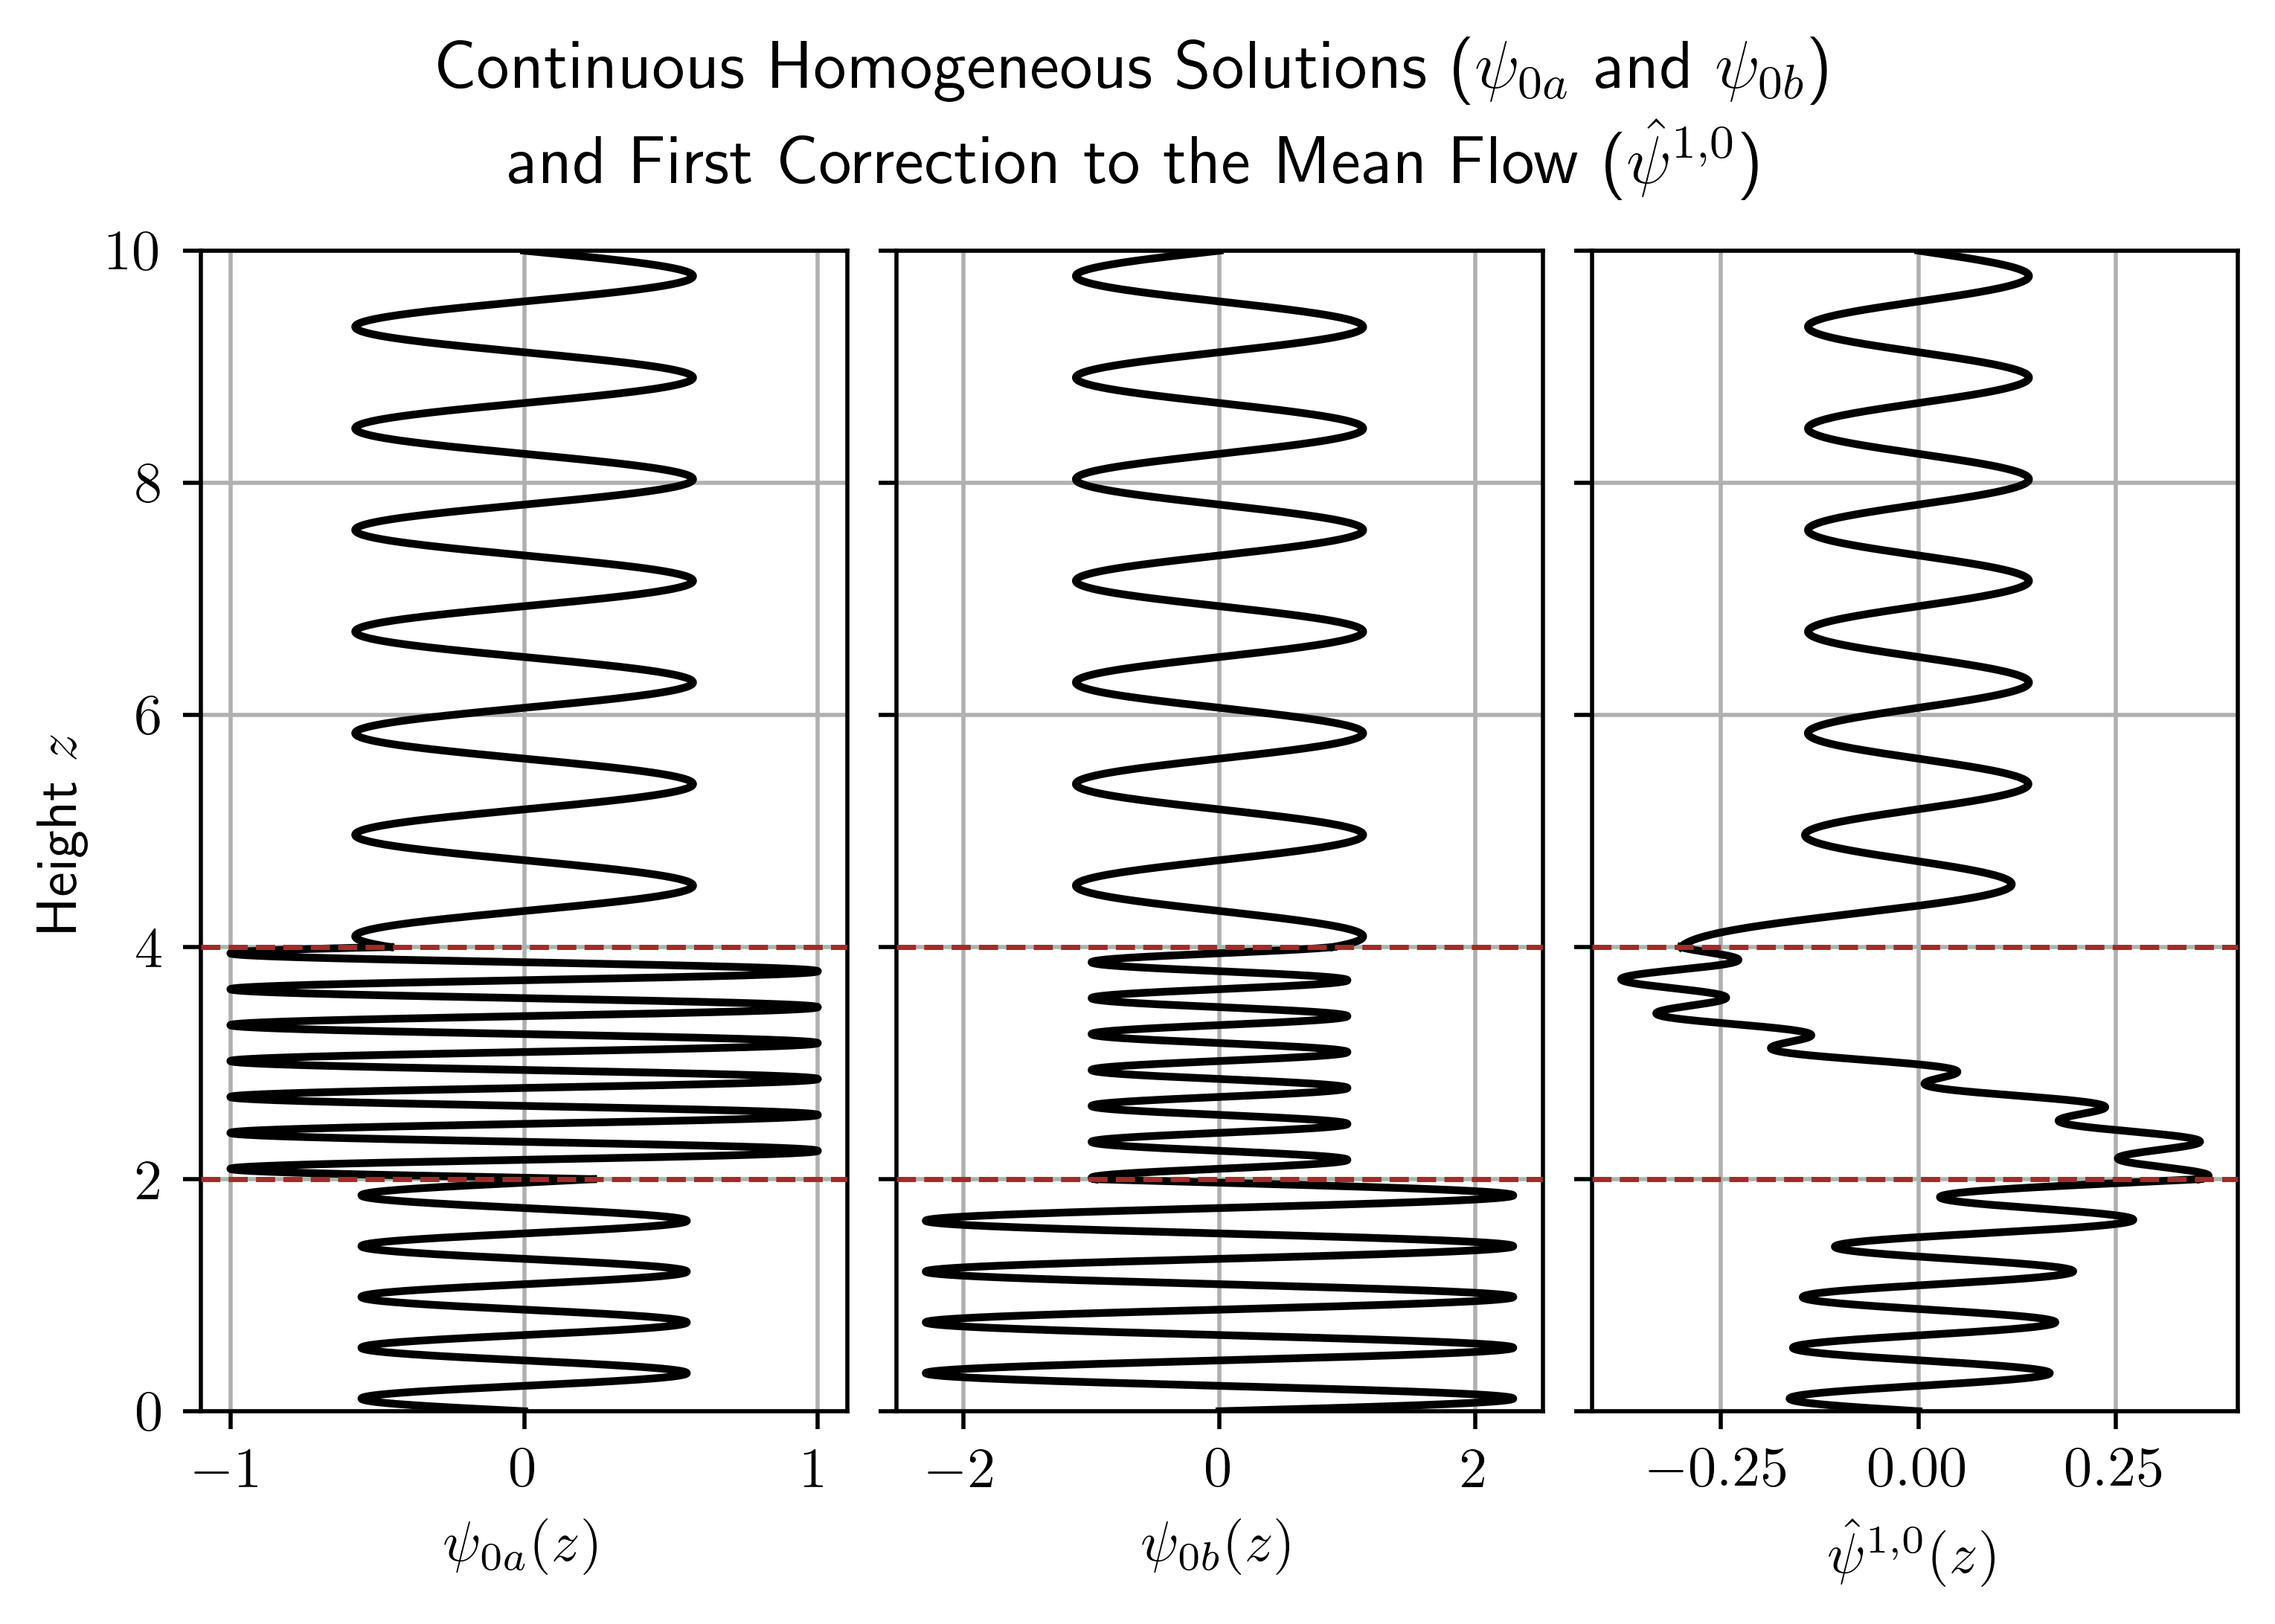

In [15]:
fig, axes = plt.subplots(layout='constrained', ncols=3, sharey=True)
fig.set_size_inches(6, 4.25)
fig.set_dpi(500)

zt = np.linspace(Hi, HT, num=1000)
zi = np.linspace(Hc, Hi, num=1000)
zc = np.linspace(0., Hc, num=1000)

axes[0].plot(sym_to_eval(psi10a_t, zt).real, zt, 'k', zorder=3)
axes[0].plot(sym_to_eval(psi10a_i, zi).real, zi, 'k', zorder=3)
axes[0].plot(sym_to_eval(psi10a_c, zc).real, zc, 'k', zorder=3)
axes[0].grid()
axes[0].set(ylim=(0, HT))
axes[0].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[0].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[0].set(xlabel=r'$\psi_{0a}(z)$', ylabel=r'Height $z$')

axes[1].plot(sym_to_eval(psi10b_t, zt).real, zt, 'k', zorder=3)
axes[1].plot(sym_to_eval(psi10b_i, zi).real, zi, 'k', zorder=3)
axes[1].plot(sym_to_eval(psi10b_c, zc).real, zc, 'k', zorder=3)
axes[1].grid()
axes[1].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[1].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[1].set(xlabel=r'$\psi_{0b}(z)$')

axes[2].plot(sym_to_eval(psih_10_t, zt).real, zt, 'k', zorder=3)
axes[2].plot(sym_to_eval(psih_10_i, zi).real, zi, 'k', zorder=3)
axes[2].plot(sym_to_eval(psih_10_c, zc).real, zc, 'k', zorder=3)
axes[2].grid()
axes[2].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[2].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[2].set(xlabel=r'$\hat\psi^{1,0}(z)$')

fig.suptitle(r'Continuous Homogeneous Solutions ($\psi_{0a}$ and $\psi_{0b}$)'+'\n'+r' and First Correction to the Mean Flow ($\hat\psi^{1,0}$)')

plt.show()

**Nonlinear terms: second correction - first harmonic (Section 4.2.3)**

In [16]:
#Correct jump in this mode due to nonlinear interface motion Eq (4.54)
J_psi21_Hi = 3/2*k**4/om**4*(N2t - N2i)*(psih_0_i.subs({z:Hi}))**3 + k/om*(psih_0_i.subs({z:Hi}))*(J_dpsi10_Hi + J_dpsi12_Hi)
J_psi21_Hc = 3/2*(1+L)**2*k**4/om**4*(N2i - N2c)*(psih_0_i.subs({z:Hc}))**3 + (1+L)*k/om*(psih_0_i.subs({z:Hc}))*(J_dpsi10_Hc + J_dpsi12_Hc)

#Particular solutions to each forcing generated in the RHS of the ODE Eq (4.53)
#Again this part is skipped in the thesis because it is so elementary ;)

#6 terms for the leading order x leading order interactions
psi21_p0aa_t = mt**2*sym.sin(mi*Hi)**3/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p0aa_i = mi**2*(-sym.sin(3*mi*z)/(8*mi**2) + z*sym.cos(mi*z)/(2*mi))
psi21_p0aa_c = mc**2*sym.sin(mi*Hc)**3/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p0ba_t = mt**2*sym.sin(mi*Hi)**2*sym.cos(mi*Hi)/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p0ba_i = mi**2*(-sym.cos(3*mi*z)/(8*mi**2) + z*sym.sin(mi*z)/(2*mi))
psi21_p0ba_c = mc**2*sym.sin(mi*Hc)**2*sym.cos(mi*Hc)/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p0ab_t = mt**2*sym.cos(mi*Hi)**2*sym.sin(mi*Hi)/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p0ab_i = -mi**2*(-sym.sin(3*mi*z)/(8*mi**2) + z*sym.cos(mi*z)/(2*mi))
psi21_p0ab_c = mc**2*sym.cos(mi*Hc)**2*sym.sin(mi*Hc)/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p0bb_t = mt**2*sym.cos(mi*Hi)**3/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p0bb_i = -mi**2*(-sym.cos(3*mi*z)/(8*mi**2) + z*sym.sin(mi*z)/(2*mi))
psi21_p0bb_c = mc**2*sym.cos(mi*Hc)**3/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p0aab_t = mt**2*sym.sin(mi*Hi)**2*sym.cos(mi*Hi)/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p0aab_i = mi**2*(-sym.cos(3*mi*z)/(8*mi**2) - z*sym.sin(mi*z)/(2*mi))
psi21_p0aab_c = mc**2*sym.sin(mi*Hc)**2*sym.cos(mi*Hc)/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p0bab_t = mt**2*sym.cos(mi*Hi)**2*sym.sin(mi*Hi)/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p0bab_i = mi**2*(sym.sin(3*mi*z)/(8*mi**2) + z*sym.cos(mi*z)/(2*mi))
psi21_p0bab_c = mc**2*sym.cos(mi*Hc)**2*sym.sin(mi*Hc)/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

#12 for the leading order x first correction interactions
psi21_p1aa_t = m0t/2*sym.sin(m0i*Hi)/sym.sin(m0t*(Hi-HT))*sym.sin(mi*Hi)/sym.sinh(mt*(Hi-HT))*(sym.sinh((mt+I*m0t)*(z-HT))/((mt+I*m0t)**2 - mt**2) + sym.sinh((mt-I*m0t)*(z-HT))/((mt-I*m0t)**2 - mt**2))
psi21_p1aa_i = -m0i/2*(sym.sin((mi+m0i)*z)/((mi+m0i)**2 - mi**2) + sym.sin((mi-m0i)*z)/((mi-m0i)**2 - mi**2))
psi21_p1aa_c = m0c/2*sym.sin(m0i*Hc)/sym.sin(m0c*Hc)*sym.sin(mi*Hc)/sym.sinh(mc*Hc)*(sym.sinh((mc+I*m0c)*z)/((mc+I*m0c)**2 - mc**2) + sym.sinh((mc-I*m0c)*z)/((mc-I*m0c)**2 - mc**2))

psi21_p1ba_t = m0t/2*sym.sin(m0i*Hi)/sym.sin(m0t*(Hi-HT))*sym.cos(mi*Hi)/sym.sinh(mt*(Hi-HT))*(sym.sinh((mt+I*m0t)*(z-HT))/((mt+I*m0t)**2 - mt**2) + sym.sinh((mt-I*m0t)*(z-HT))/((mt-I*m0t)**2 - mt**2))
psi21_p1ba_i = -m0i/2*(sym.cos((mi+m0i)*z)/((mi+m0i)**2 - mi**2) + sym.cos((mi-m0i)*z)/((mi-m0i)**2 - mi**2))
psi21_p1ba_c = m0c/2*sym.sin(m0i*Hc)/sym.sin(m0c*Hc)*sym.cos(mi*Hc)/sym.sinh(mc*Hc)*(sym.sinh((mc+I*m0c)*z)/((mc+I*m0c)**2 - mc**2) + sym.sinh((mc-I*m0c)*z)/((mc-I*m0c)**2 - mc**2))

psi21_p1ab_t = m0t/2*sym.cos(m0i*Hi)/sym.sin(m0t*(Hi-HT))*sym.sin(mi*Hi)/sym.sinh(mt*(Hi-HT))*(sym.sinh((mt+I*m0t)*(z-HT))/((mt+I*m0t)**2 - mt**2) + sym.sinh((mt-I*m0t)*(z-HT))/((mt-I*m0t)**2 - mt**2))
psi21_p1ab_i = -m0i/2*(sym.cos((mi+m0i)*z)/((mi+m0i)**2 - mi**2) - sym.cos((mi-m0i)*z)/((mi-m0i)**2 - mi**2))
psi21_p1ab_c = m0c/2*sym.cos(m0i*Hc)/sym.sin(m0c*Hc)*sym.sin(mi*Hc)/sym.sinh(mc*Hc)*(sym.sinh((mc+I*m0c)*z)/((mc+I*m0c)**2 - mc**2) + sym.sinh((mc-I*m0c)*z)/((mc-I*m0c)**2 - mc**2))

psi21_p1bb_t = m0t/2*sym.cos(m0i*Hi)/sym.sin(m0t*(Hi-HT))*sym.cos(mi*Hi)/sym.sinh(mt*(Hi-HT))*(sym.sinh((mt+I*m0t)*(z-HT))/((mt+I*m0t)**2 - mt**2) + sym.sinh((mt-I*m0t)*(z-HT))/((mt-I*m0t)**2 - mt**2))
psi21_p1bb_i = m0i/2*(sym.sin((mi+m0i)*z)/((mi+m0i)**2 - mi**2) - sym.sin((mi-m0i)*z)/((mi-m0i)**2 - mi**2))
psi21_p1bb_c = m0c/2*sym.cos(m0i*Hc)/sym.sin(m0c*Hc)*sym.cos(mi*Hc)/sym.sinh(mc*Hc)*(sym.sinh((mc+I*m0c)*z)/((mc+I*m0c)**2 - mc**2) + sym.sinh((mc-I*m0c)*z)/((mc-I*m0c)**2 - mc**2))

psi21_p1ac_t = m0t/2*(-J_psi10_pd_Hi + sym.sin(m0i*Hi))/sym.sin(m0t*(Hi-HT))*sym.sin(mi*Hi)/sym.sinh(mt*(Hi-HT))*(sym.sinh((mt+I*m0t)*(z-HT))/((mt+I*m0t)**2 - mt**2) + sym.sinh((mt-I*m0t)*(z-HT))/((mt-I*m0t)**2 - mt**2))
psi21_p1ac_i = -m0i/2*(sym.sin((mi+m0i)*z)/((mi+m0i)**2 - mi**2) + sym.sin((mi-m0i)*z)/((mi-m0i)**2 - mi**2))
psi21_p1ac_c = m0c/2*(J_psi10_pd_Hc + sym.sin(m0i*Hc))/sym.sin(m0c*Hc)*sym.sin(mi*Hc)/sym.sinh(mc*Hc)*(sym.sinh((mc+I*m0c)*z)/((mc+I*m0c)**2 - mc**2) + sym.sinh((mc-I*m0c)*z)/((mc-I*m0c)**2 - mc**2))

psi21_p1bc_t = m0t/2*(-J_psi10_pd_Hi + sym.sin(m0i*Hi))/sym.sin(m0t*(Hi-HT))*sym.cos(mi*Hi)/sym.sinh(mt*(Hi-HT))*(sym.sinh((mt+I*m0t)*(z-HT))/((mt+I*m0t)**2 - mt**2) + sym.sinh((mt-I*m0t)*(z-HT))/((mt-I*m0t)**2 - mt**2))
psi21_p1bc_i = -m0i/2*(sym.cos((mi+m0i)*z)/((mi+m0i)**2 - mi**2) + sym.cos((mi-m0i)*z)/((mi-m0i)**2 - mi**2))
psi21_p1bc_c = m0c/2*(J_psi10_pd_Hc + sym.sin(m0i*Hc))/sym.sin(m0c*Hc)*sym.cos(mi*Hc)/sym.sinh(mc*Hc)*(sym.sinh((mc+I*m0c)*z)/((mc+I*m0c)**2 - mc**2) + sym.sinh((mc-I*m0c)*z)/((mc-I*m0c)**2 - mc**2))

psi21_p1apa_t = mt**2/(m0t**2 + 4*mt**2)*sym.sin(mi*Hi)**3/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p1apa_i = mi**2/(m0i**2 - 4*mi**2)*(-sym.sin(3*mi*z)/(8*mi**2) + z*sym.cos(mi*z)/(2*mi))
psi21_p1apa_c = mc**2/(m0c**2 + 4*mc**2)*sym.sin(mi*Hc)**3/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p1bpa_t = mt**2/(m0t**2 + 4*mt**2)*sym.sin(mi*Hi)**2*sym.cos(mi*Hi)/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p1bpa_i = mi**2/(m0i**2 - 4*mi**2)*(-sym.cos(3*mi*z)/(8*mi**2) + z*sym.sin(mi*z)/(2*mi))
psi21_p1bpa_c = mc**2/(m0c**2 + 4*mc**2)*sym.sin(mi*Hc)**2*sym.cos(mi*Hc)/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p1apb_t = mt**2/(m0t**2 + 4*mt**2)*sym.sin(mi*Hi)*sym.cos(mi*Hi)**2/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p1apb_i = mi**2/(m0i**2 - 4*mi**2)*(sym.sin(3*mi*z)/(8*mi**2) - z*sym.cos(mi*z)/(2*mi))
psi21_p1apb_c = mc**2/(m0c**2 + 4*mc**2)*sym.sin(mi*Hc)*sym.cos(mi*Hc)**2/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p1bpb_t = mt**2/(m0t**2 + 4*mt**2)*sym.cos(mi*Hi)**3/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p1bpb_i = mi**2/(m0i**2 - 4*mi**2)*(sym.cos(3*mi*z)/(8*mi**2) - z*sym.sin(mi*z)/(2*mi))
psi21_p1bpb_c = mc**2/(m0c**2 + 4*mc**2)*sym.cos(mi*Hc)**3/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p1apab_t = mt**2/2/(m0t**2 + 4*mt**2)*sym.sin(2*mi*Hi)*sym.sin(mi*Hi)/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p1apab_i = mi**2/(m0i**2 - 4*mi**2)*(-sym.cos(3*mi*z)/(8*mi**2) - z*sym.sin(mi*z)/(2*mi))
psi21_p1apab_c = mc**2/2/(m0c**2 + 4*mc**2)*sym.sin(2*mi*Hc)*sym.sin(mi*Hc)/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p1bpab_t = mt**2/2/(m0t**2 + 4*mt**2)*sym.sin(2*mi*Hi)*sym.cos(mi*Hi)/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p1bpab_i = mi**2/(m0i**2 - 4*mi**2)*(sym.sin(3*mi*z)/(8*mi**2) + z*sym.cos(mi*z)/(2*mi))
psi21_p1bpab_c = mc**2/2/(m0c**2 + 4*mc**2)*sym.sin(2*mi*Hc)*sym.cos(mi*Hc)/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

#Full Paticular solution without correct continuity
psi21_pd_t = N2t*(2*k**3/om**3 - k/om/om_p**2 - k**2/om**2/om_p)*(\
             (m0t**2*k/om*(1 + 2*k/om*om_p)*(1-k/om*om_p)*(v1[0]**3*psi21_p1apa_t + v1[0]**2*v1[1]*psi21_p1bpa_t + 2*v1[0]**2*v1[1]*psi21_p1apab_t + \
                                                           2*v1[0]*v1[1]**2*psi21_p1bpab_t + v1[0]*v1[1]**2*psi21_p1apb_t + v1[1]**3*psi21_p1bpb_t)) \
             + v1[0]*psi21_p1ac_t + v1[1]*psi21_p1bc_t + v1[0]*W10[0,0]*psi21_p1aa_t + v1[1]*W10[0,0]*psi21_p1ba_t + v1[0]*W10[1,0]*psi21_p1ab_t + v1[1]*W10[1,0]*psi21_p1bb_t) + \
             N2t*(k**2/om**2/om_p**2*(1+2*k/om*om_p)*(1-k/om*om_p) + k**3/om**3/om_p*(1-k/om*om_p))* \
             (v1[0]**3*psi21_p0aa_t + v1[0]**2*v1[1]*psi21_p0ba_t + 2*v1[0]**2*v1[1]*psi21_p0aab_t + 2*v1[0]*v1[1]**2*psi21_p0bab_t \
              + v1[0]*v1[1]**2*psi21_p0ab_t + v1[1]**3*psi21_p0bb_t)
psi21_pd_i = N2i*(2*k**3/om**3 - k/om/om_p**2 - k**2/om**2/om_p)*(\
             (m0i**2*k/om*(1 + 2*k/om*om_p)*(1-k/om*om_p)*(v1[0]**3*psi21_p1apa_i + v1[0]**2*v1[1]*psi21_p1bpa_i + 2*v1[0]**2*v1[1]*psi21_p1apab_i + \
                                                           2*v1[0]*v1[1]**2*psi21_p1bpab_i + v1[0]*v1[1]**2*psi21_p1apb_i + v1[1]**3*psi21_p1bpb_i)) \
             + v1[0]*psi21_p1ac_i + v1[1]*psi21_p1bc_i + v1[0]*W10[0,0]*psi21_p1aa_i + v1[1]*W10[0,0]*psi21_p1ba_i + v1[0]*W10[1,0]*psi21_p1ab_i + v1[1]*W10[1,0]*psi21_p1bb_i) + \
             N2i*(k**2/om**2/om_p**2*(1+2*k/om*om_p)*(1-k/om*om_p) + k**3/om**3/om_p*(1-k/om*om_p))* \
             (v1[0]**3*psi21_p0aa_i + v1[0]**2*v1[1]*psi21_p0ba_i + 2*v1[0]**2*v1[1]*psi21_p0aab_i + 2*v1[0]*v1[1]**2*psi21_p0bab_i \
              + v1[0]*v1[1]**2*psi21_p0ab_i + v1[1]**3*psi21_p0bb_i)
psi21_pd_c = N2c*(2*k**3/om**3 - k/om/om_p**2 - k**2/om**2/om_p)*(\
             (m0c**2*k/om*(1 + 2*k/om*om_p)*(1-k/om*om_p)*(v1[0]**3*psi21_p1apa_c + v1[0]**2*v1[1]*psi21_p1bpa_c + 2*v1[0]**2*v1[1]*psi21_p1apab_c + \
                                                           2*v1[0]*v1[1]**2*psi21_p1bpab_c + v1[0]*v1[1]**2*psi21_p1apb_c + v1[1]**3*psi21_p1bpb_c)) \
             + v1[0]*psi21_p1ac_c + v1[1]*psi21_p1bc_c + v1[0]*W10[0,0]*psi21_p1aa_c + v1[1]*W10[0,0]*psi21_p1ba_c + v1[0]*W10[1,0]*psi21_p1ab_c + v1[1]*W10[1,0]*psi21_p1bb_c) + \
             N2c*(k**2/om**2/om_p**2*(1+2*k/om*om_p)*(1-k/om*om_p) + k**3/om**3/om_p*(1-k/om*om_p))* \
             (v1[0]**3*psi21_p0aa_c + v1[0]**2*v1[1]*psi21_p0ba_c + 2*v1[0]**2*v1[1]*psi21_p0aab_c + 2*v1[0]*v1[1]**2*psi21_p0bab_c \
              + v1[0]*v1[1]**2*psi21_p0ab_c + v1[1]**3*psi21_p0bb_c)

#Correct jumps at Hi and Hc
J_psi21_pd_Hi = psi21_pd_t.subs({z:Hi}) - psi21_pd_i.subs({z:Hi})
J_psi21_pd_Hc = psi21_pd_i.subs({z:Hc}) - psi21_pd_c.subs({z:Hc})

psi21_p_t = psi21_pd_t + (J_psi21_Hi - J_psi21_pd_Hi + sym.sin(mi*Hi))*sym.sinh(mt*(z-HT))/sym.sinh(mt*(Hi-HT))
psi21_p_i = psi21_pd_i + sym.sin(mi*z)
psi21_p_c = psi21_pd_c + (-J_psi21_Hc + J_psi21_pd_Hc + sym.sin(mi*Hc))*sym.sinh(mc*z)/sym.sinh(mc*Hc)

#Continuous derivative at Hi using the right amount of phi Eq (4.55-4.56)
J_dpsi21_Hi = sym.diff(psi21_p_t, z).subs({z:Hi}) - sym.diff(psi21_p_i, z).subs({z:Hi})

#Eq (4.56)
alpha_21 = ( (N2t - N2i)*(5/2*k**4/om**4*psih_0_i**2*sym.diff(psih_0_i, z) - 2*k**3/om**3*psih_0_i*psih_12_i + k**2/om**2*Zih_10*psih_0_i + \
                          k/om/om_p**2*psih_0_i*(k/om*(1+2*k/om*om_p)*(1-k/om*om_p)*sym.diff(psih_0_i**2, z) - psih_10_i)).subs({z:Hi})\
            - J_dpsi21_Hi )/J_dphi

#Eq (4.55)
psih_21_t = psi21_p_t + alpha_21*phi_t
psih_21_i = psi21_p_i + alpha_21*phi_i
psih_21_c = psi21_p_c + alpha_21*phi_c

#second correction - first harmonic (nonlinear) buoyancy
Bh_21_t = N2t*k/om*psih_21_t - N2t*k**2/om**2*psih_0_t*sym.diff(psih_10_t, z) + k/om*psih_0_t*sym.diff(Bh_10_t, z)
Bh_21_i = N2i*k/om*psih_21_i - N2i*k**2/om**2*psih_0_i*sym.diff(psih_10_i, z) + k/om*psih_0_i*sym.diff(Bh_10_i, z)
Bh_21_c = N2c*k/om*psih_21_c - N2c*k**2/om**2*psih_0_c*sym.diff(psih_10_c, z) + k/om*psih_0_c*sym.diff(Bh_10_c, z)

**Figure 4.5**

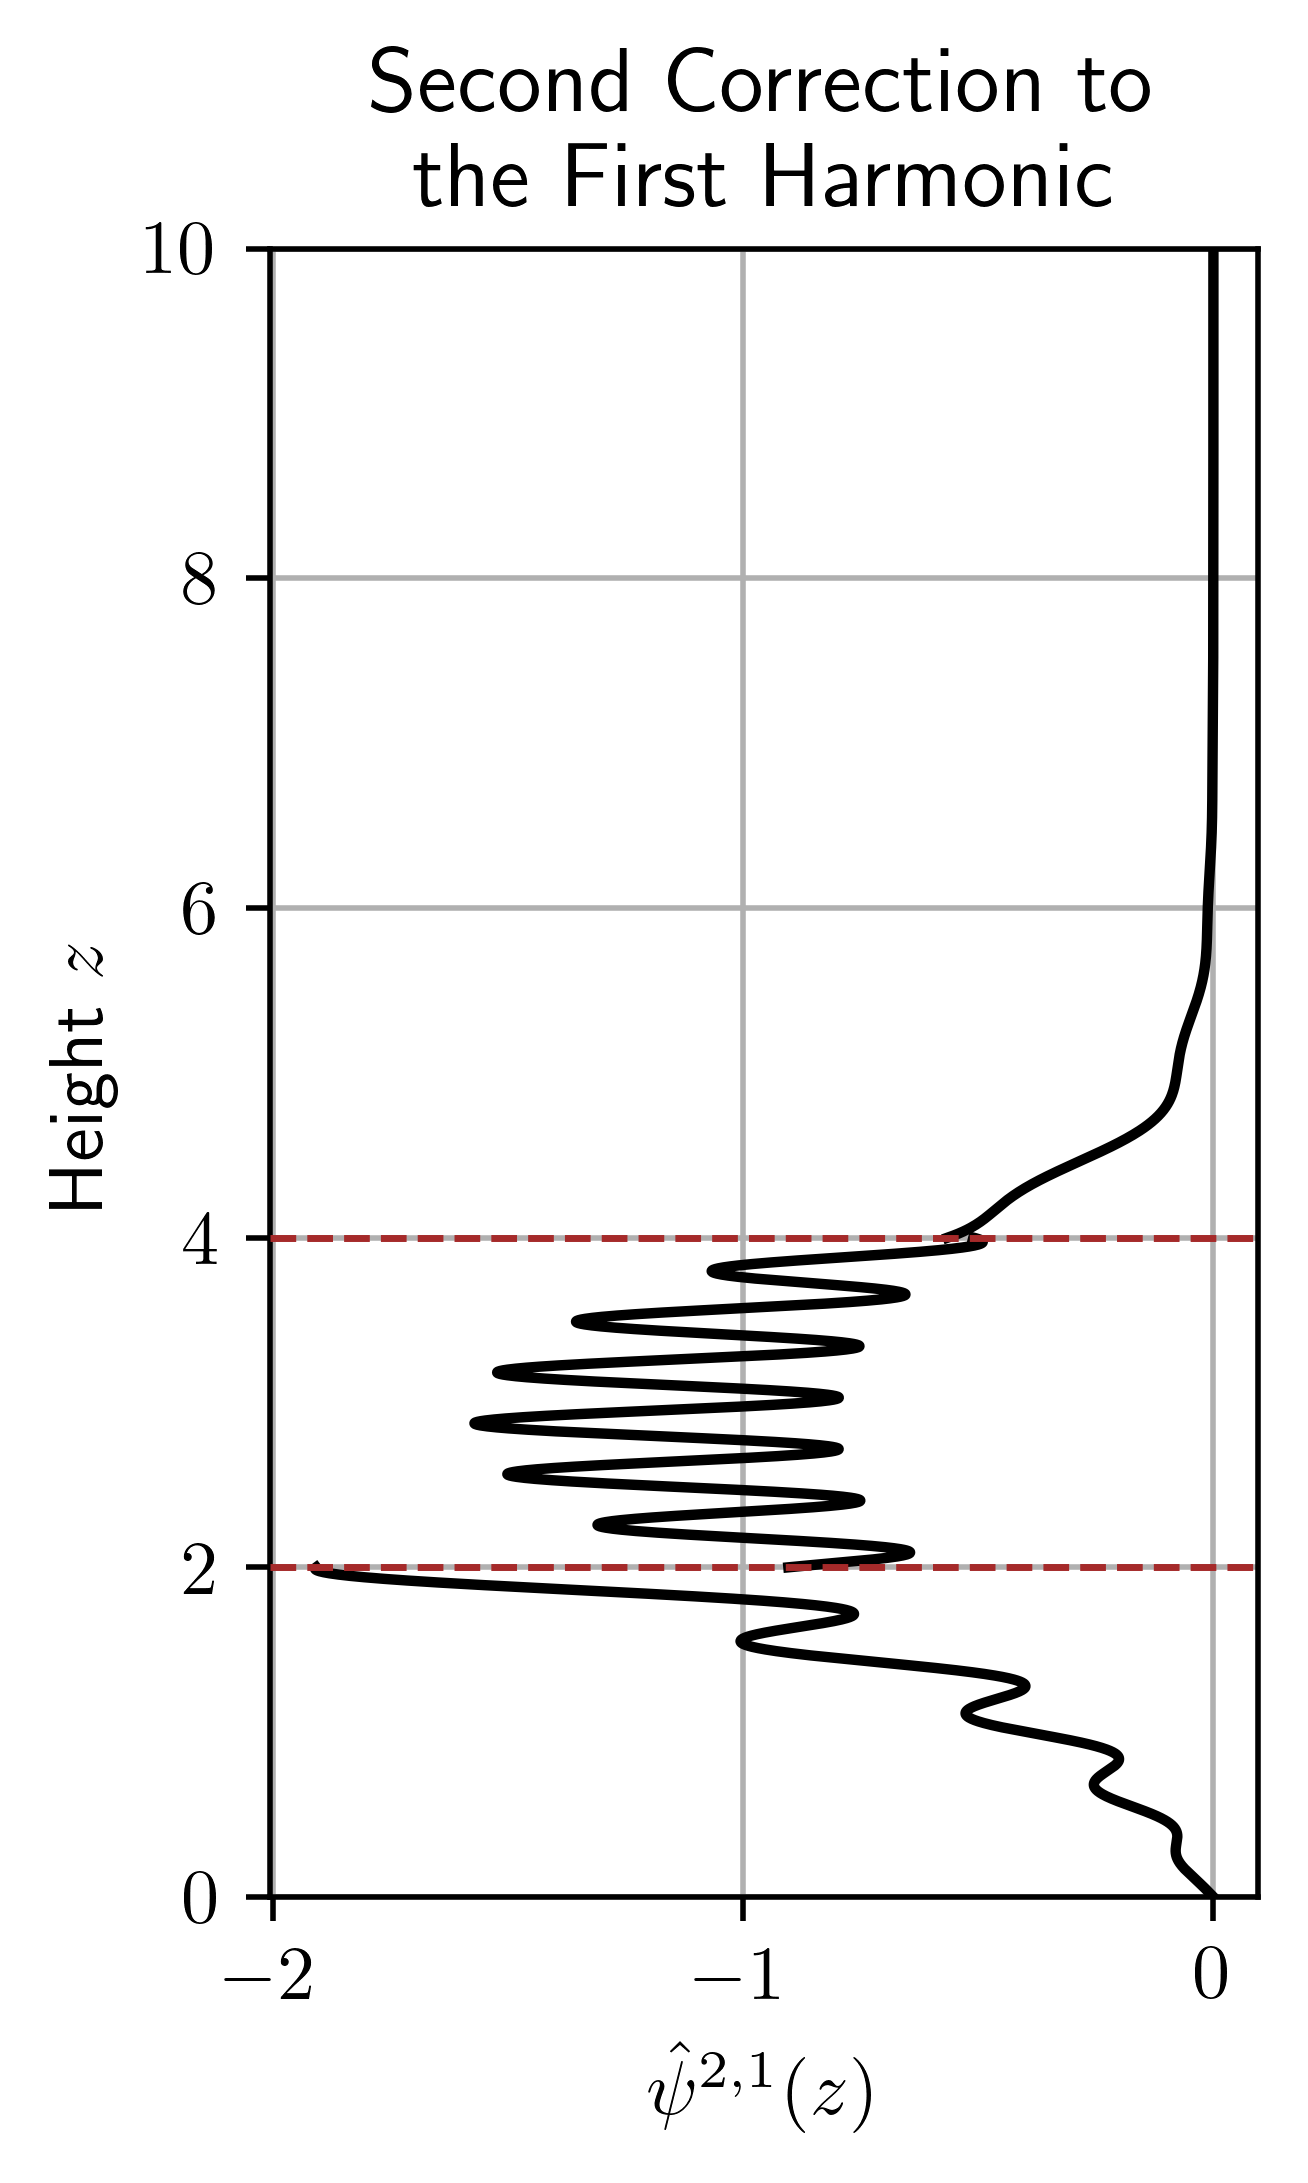

In [17]:
fig, ax = plt.subplots(layout='constrained', sharey=True)
fig.set_size_inches(2.5, 4.25)
fig.set_dpi(500)

zt = np.linspace(Hi, HT, num=1000)
zi = np.linspace(Hc, Hi, num=1000)
zc = np.linspace(0., Hc, num=1000)

ax.plot(sym_to_eval(psih_21_t, zt).real, zt, 'k', zorder=3)
ax.plot(sym_to_eval(psih_21_i, zi).real, zi, 'k', zorder=3)
ax.plot(sym_to_eval(psih_21_c, zc).real, zc, 'k', zorder=3)
ax.grid()
ax.set(ylim=(0, HT))
ax.axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
ax.axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
ax.set(xlabel=r'$\hat{\psi}^{2,1}(z)$', ylabel=r'Height $z$')

ax.set_title('Second Correction to\nthe First Harmonic')

plt.show()